### Connect to WRDS and call the library

In [1]:
pip install wrds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import wrds
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
db = wrds.Connection(wrds_username='linzhangzl')
db.create_pgpass_file() # then you don't need to enter password next time.
#db.close()

Loading library list...
Done
Enter your WRDS username [linzhangzl]:linzhangzl
Enter your password:··········


### Question 1

##### Prepare Financial Data

In [4]:
# Get Raw Compustat Fundamentals Data - Annual (FYEAR allos for identification of year)
compnames = db.raw_sql("""
                      SELECT DISTINCT gvkey, cik, FYEAR, at, sale, ppent, rect, invt, che, oancf, dp, dlc, act, lct
                      FROM comp.funda 
                      WHERE FYEAR in (2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021)
                      """) 
compnames

,gvkey,cik,fyear,at,sale,ppent,rect,invt,che,oancf,dp,dlc,act,lct
0,006682,0000096223,2018.0,47131.095,4788.016,351.000,12825.613,18873.142,8752.527,691.103,118.356,19199.707,NaN,NaN
1,004990,0000039911,2021.0,12761.000,16670.000,6712.000,NaN,NaN,NaN,NaN,504.000,NaN,NaN,NaN
2,062689,0000086312,2011.0,104602.000,25446.000,NaN,22985.000,0.000,9709.000,2169.000,802.000,350.000,NaN,NaN
3,026256,None,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,016705,0000701347,2021.0,7419.089,NaN,119.795,NaN,NaN,NaN,NaN,10.452,0.000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218134,029760,0001657788,2017.0,295.291,30.664,282.381,NaN,NaN,NaN,NaN,15.660,NaN,NaN,NaN
218135,031596,0000022606,2020.0,34466.000,5904.000,24564.000,799.000,170.000,362.000,1324.000,1133.000,676.000,1659.000,2393.00
218136,021352,0001606498,2015.0,NaN,509.000,115.900,NaN,NaN,NaN,NaN,42.800,NaN,NaN,NaN
218137,061420,0000945841,2018.0,1240.871,2998.097,106.964,207.801,672.579,16.358,118.656,27.224,9.168,915.244,305.61


In [5]:
# Get Industry Variable from company table 
indusdetail = db.raw_sql(
    """
    SELECT SIC, gvkey, cik
    FROM comp.company
    """
)
indusdetail

,sic,gvkey,cik
0,3089,001000,None
1,5812,001001,0000723576
2,3825,001002,0001306124
3,5712,001003,0000730052
4,5080,001004,0000001750
...,...,...,...
52549,1400,352257,None
52550,4400,352262,0001944057
52551,2834,353444,None
52552,3621,353945,0001948862


In [6]:
# Merge industry details with companyname file
CompIndus = pd.merge(compnames, indusdetail, on=['gvkey', 'cik'], how='left')
CompIndus

,gvkey,cik,fyear,at,sale,ppent,rect,invt,che,oancf,dp,dlc,act,lct,sic
0,006682,0000096223,2018.0,47131.095,4788.016,351.000,12825.613,18873.142,8752.527,691.103,118.356,19199.707,NaN,NaN,6211
1,004990,0000039911,2021.0,12761.000,16670.000,6712.000,NaN,NaN,NaN,NaN,504.000,NaN,NaN,NaN,5651
2,062689,0000086312,2011.0,104602.000,25446.000,NaN,22985.000,0.000,9709.000,2169.000,802.000,350.000,NaN,NaN,6331
3,026256,None,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6722
4,016705,0000701347,2021.0,7419.089,NaN,119.795,NaN,NaN,NaN,NaN,10.452,0.000,NaN,NaN,6020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218134,029760,0001657788,2017.0,295.291,30.664,282.381,NaN,NaN,NaN,NaN,15.660,NaN,NaN,NaN,1311
218135,031596,0000022606,2020.0,34466.000,5904.000,24564.000,799.000,170.000,362.000,1324.000,1133.000,676.000,1659.000,2393.00,4911
218136,021352,0001606498,2015.0,NaN,509.000,115.900,NaN,NaN,NaN,NaN,42.800,NaN,NaN,NaN,3842
218137,061420,0000945841,2018.0,1240.871,2998.097,106.964,207.801,672.579,16.358,118.656,27.224,9.168,915.244,305.61,5090


In [7]:
CompIndus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218139 entries, 0 to 218138
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   gvkey   218139 non-null  object 
 1   cik     172779 non-null  object 
 2   fyear   218139 non-null  float64
 3   at      170690 non-null  float64
 4   sale    160262 non-null  float64
 5   ppent   164264 non-null  float64
 6   rect    92545 non-null   float64
 7   invt    96140 non-null   float64
 8   che     93644 non-null   float64
 9   oancf   92667 non-null   float64
 10  dp      163130 non-null  float64
 11  dlc     106728 non-null  float64
 12  act     79644 non-null   float64
 13  lct     79851 non-null   float64
 14  sic     218139 non-null  object 
dtypes: float64(12), object(3)
memory usage: 26.6+ MB


In [8]:
# Drop financial firms: firms with SIC in range of either (4400 and 5000) or (6000 and 6500)
# Convert the 'sic' column to numeric values (integer)
CompIndus['sic'] = pd.to_numeric(CompIndus['sic'], errors='coerce').astype('Int64')

# Filter out the firms with SIC codes in the specified ranges
CompIndus = CompIndus[~((CompIndus['sic'] >= 4400) & (CompIndus['sic'] < 5000) | (CompIndus['sic'] >= 6000) & (CompIndus['sic'] < 6500))]
CompIndus

,gvkey,cik,fyear,at,sale,ppent,rect,invt,che,oancf,dp,dlc,act,lct,sic
1,004990,0000039911,2021.0,12761.000,16670.000,6712.000,NaN,NaN,NaN,NaN,504.000,NaN,NaN,NaN,5651
3,026256,None,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6722
5,166009,None,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6722
7,004156,0000350846,2011.0,104.697,300.808,33.530,24.745,36.033,1.031,14.470,3.031,0.246,69.483,33.684,3713
8,176260,0001381640,2015.0,10409.782,3974.800,5760.229,272.864,33.074,2652.880,522.026,470.634,136.297,3020.161,1214.686,7990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218133,037138,None,2021.0,533.629,733.380,184.038,NaN,NaN,NaN,NaN,38.061,NaN,NaN,NaN,7340
218134,029760,0001657788,2017.0,295.291,30.664,282.381,NaN,NaN,NaN,NaN,15.660,NaN,NaN,NaN,1311
218136,021352,0001606498,2015.0,NaN,509.000,115.900,NaN,NaN,NaN,NaN,42.800,NaN,NaN,NaN,3842
218137,061420,0000945841,2018.0,1240.871,2998.097,106.964,207.801,672.579,16.358,118.656,27.224,9.168,915.244,305.610,5090


##### Prepare Restatement Data

In [9]:
# Get Raw Restatement Data
restatements = db.raw_sql("""
                      SELECT DISTINCT 
                        company_fkey, 
                        res_sec_invest,
                        res_begin_date,  
                        res_end_date
                      FROM audit.auditnonreli
                      ORDER BY company_fkey DESC
                      """) 
restatements

,company_fkey,res_sec_invest,res_begin_date,res_end_date
0,0001909747,0.0,2022-01-01,2022-03-31
1,0001905956,0.0,2020-07-01,2021-06-30
2,0001903392,0.0,2022-07-01,2022-09-30
3,0001891791,0.0,2020-01-01,2020-12-31
4,0001889823,0.0,2019-01-01,2019-12-31
...,...,...,...,...
20593,0000001923,0.0,2008-11-01,2009-01-31
20594,0000001923,0.0,2008-05-01,2011-01-31
20595,0000001853,0.0,2005-01-01,2005-12-31
20596,0000001853,0.0,2006-01-01,2006-06-30


In [10]:
restatements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20598 entries, 0 to 20597
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   company_fkey    20598 non-null  object 
 1   res_sec_invest  20598 non-null  float64
 2   res_begin_date  20598 non-null  object 
 3   res_end_date    20598 non-null  object 
dtypes: float64(1), object(3)
memory usage: 643.8+ KB


In [11]:
# Step 1: Convert date columns to datetime objects
restatements['res_begin_date'] = pd.to_datetime(restatements['res_begin_date'])
restatements['res_end_date'] = pd.to_datetime(restatements['res_end_date'])

In [12]:
# Step 2: Create a new DataFrame with a range of years from 2012 to 2021 for each company
years = range(2012, 2022)  # 2012 to 2021 inclusive
companies = restatements['company_fkey'].unique()
firm_years = pd.DataFrame([(c, y) for c in companies for y in years], columns=['company_fkey', 'firm_year'])

In [13]:
# Step 3: Merge the new DataFrame with the restatements DataFrame
restatements_extended = pd.merge(
    firm_years, restatements,
    left_on='company_fkey',
    right_on='company_fkey',
    how='left'
)

restatements_extended['firm_year'] = pd.to_datetime(restatements_extended['firm_year'], format='%Y')

In [14]:
restatements_extended

,company_fkey,firm_year,res_sec_invest,res_begin_date,res_end_date
0,0001909747,2012-01-01,0.0,2022-01-01,2022-03-31
1,0001909747,2013-01-01,0.0,2022-01-01,2022-03-31
2,0001909747,2014-01-01,0.0,2022-01-01,2022-03-31
3,0001909747,2015-01-01,0.0,2022-01-01,2022-03-31
4,0001909747,2016-01-01,0.0,2022-01-01,2022-03-31
...,...,...,...,...,...
205975,0000001750,2017-01-01,0.0,2015-03-01,2015-05-31
205976,0000001750,2018-01-01,0.0,2015-03-01,2015-05-31
205977,0000001750,2019-01-01,0.0,2015-03-01,2015-05-31
205978,0000001750,2020-01-01,0.0,2015-03-01,2015-05-31


In [15]:
restatements_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205980 entries, 0 to 205979
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   company_fkey    205980 non-null  object        
 1   firm_year       205980 non-null  datetime64[ns]
 2   res_sec_invest  205980 non-null  float64       
 3   res_begin_date  205980 non-null  datetime64[ns]
 4   res_end_date    205980 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(1)
memory usage: 9.4+ MB


In [16]:
# Convert the datatime variables to year variable
restatements_extended['firm_year'] = restatements_extended['firm_year'].dt.year.astype(float)
restatements_extended['res_begin_date'] = restatements_extended['res_begin_date'].dt.year.astype(float)
restatements_extended['res_end_date'] = restatements_extended['res_end_date'].dt.year.astype(float)

In [17]:
# Step 4: Filter rows where firm_year is within the range of res_begin_date and res_end_date
restatements_extended = restatements_extended[
    (restatements_extended['firm_year'] >= restatements_extended['res_begin_date']) &
    (restatements_extended['firm_year'] <= restatements_extended['res_end_date'])
]


# Filter the DataFrame for years 2012 to 2018
restatements_extended_training = restatements_extended[(restatements_extended['firm_year'] >= 2012) & (restatements_extended['firm_year'] <= 2018)]

# Add another column to indicate the all restatement 
restatements_extended_training['all_res'] = 1

# Filter the DataFrame for years 2019 to 2021
restatements_extended_testing = restatements_extended[(restatements_extended['firm_year'] >= 2019) & (restatements_extended['firm_year'] <= 2021)]

# Add another column to indicate the all restatement 
restatements_extended_testing['all_res'] = 1

<ipython-input-17-4e9087245095>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restatements_extended_training['all_res'] = 1
<ipython-input-17-4e9087245095>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restatements_extended_testing['all_res'] = 1


In [18]:
# Step 5: Reset index
restatements_extended_training.reset_index(drop=True, inplace=True)
restatements_extended_testing.reset_index(drop=True, inplace=True)

#### Jones Model

##### Calculate Accruals

In [19]:
CompIndus_Jones_original = CompIndus[['gvkey', 'cik', 'fyear', 'sic', 'at', 'sale', 'ppent', 'act', 'lct','dp','che']]

In [20]:
CompIndus_Jones_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175578 entries, 1 to 218138
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   gvkey   175578 non-null  object 
 1   cik     134002 non-null  object 
 2   fyear   175578 non-null  float64
 3   sic     175578 non-null  Int64  
 4   at      131930 non-null  float64
 5   sale    131096 non-null  float64
 6   ppent   126906 non-null  float64
 7   act     68736 non-null   float64
 8   lct     68864 non-null   float64
 9   dp      126489 non-null  float64
 10  che     73288 non-null   float64
dtypes: Int64(1), float64(8), object(2)
memory usage: 16.2+ MB


In [21]:
# Drop missing observations from the final sample
CompIndus_Jones_original = CompIndus_Jones_original.dropna()

In [22]:
CompIndus_Jones_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59696 entries, 7 to 218137
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gvkey   59696 non-null  object 
 1   cik     59696 non-null  object 
 2   fyear   59696 non-null  float64
 3   sic     59696 non-null  Int64  
 4   at      59696 non-null  float64
 5   sale    59696 non-null  float64
 6   ppent   59696 non-null  float64
 7   act     59696 non-null  float64
 8   lct     59696 non-null  float64
 9   dp      59696 non-null  float64
 10  che     59696 non-null  float64
dtypes: Int64(1), float64(8), object(2)
memory usage: 5.5+ MB


In [23]:
CompIndus_Jones = CompIndus_Jones_original.copy()

# Filter the DataFrame for years 2011 to 2018
CompIndus_Jones = CompIndus_Jones[(CompIndus_Jones['fyear'] >= 2011) & (CompIndus_Jones['fyear'] <= 2018)]

# Further filter the company by the first two digits of SIC
CompIndus_Jones['sic2'] = CompIndus_Jones['sic'].astype(str).str[:2].astype(int)

# Sort the DataFrame by 'gvkey' and 'fyear'
CompIndus_Jones = CompIndus_Jones.sort_values(by=['gvkey', 'fyear'])

# Calculate the change in current assets, change in cash, and change in current liabilities
CompIndus_Jones['delta_ca'] = CompIndus_Jones.groupby('gvkey')['act'].diff()
CompIndus_Jones['delta_cash'] = CompIndus_Jones.groupby('gvkey')['che'].diff()
CompIndus_Jones['delta_cl'] = CompIndus_Jones.groupby('gvkey')['lct'].diff()
CompIndus_Jones['delta_revenue'] = CompIndus_Jones.groupby('gvkey')['sale'].diff()

# Calculate total accruals
CompIndus_Jones['total_accruals'] = CompIndus_Jones['delta_ca'] - CompIndus_Jones['delta_cash'] - CompIndus_Jones['delta_cl'] - CompIndus_Jones['dp']

# Calculate the independent variables for the Jones model
CompIndus_Jones['lagged_total_assets'] = CompIndus_Jones.groupby('gvkey')['at'].shift(1)

# Drop rows with missing values in 'delta_sale', 'ppent', or 'lagged_total_assets' columns
CompIndus_Jones = CompIndus_Jones.dropna(subset=['delta_ca', 'delta_cash', 'delta_cl', 'delta_revenue', 'ppent', 'lagged_total_assets'])

In [24]:
# Estimate the Jones model
def jones_regression(group):

    # Check if the group has enough observations
    if len(group) >= 2:
        
        y = group['total_accruals'] / group['lagged_total_assets']
        X = group[['delta_revenue', 'ppent', 'lagged_total_assets']]
        X['delta_revenue'] = X['delta_revenue'] / group['lagged_total_assets']
        X['ppent'] = X['ppent'] / group['lagged_total_assets']
        X['lagged_total_assests'] = 1 / group['lagged_total_assets']
        X = sm.add_constant(X)
    
    
        # Drop rows with missing or infinite values in the independent variables
        X = X.replace([np.inf, -np.inf], np.nan).dropna()

        # Align the indices of endog (y) and exog (X)
        y = y.loc[X.index]

        model = sm.OLS(y, X, missing='drop').fit()

        group['nondiscretionary_accruals'] = model.predict(X)
        group['discretionary_accruals'] = abs(group['total_accruals'] / group['lagged_total_assets'] - group['nondiscretionary_accruals'])
        return group, model

    else:
        return group, None  # Return None for the model if there are not enough observations


CompIndus_Jones, models = zip(*CompIndus_Jones.groupby(['sic2', 'fyear']).apply(jones_regression))
CompIndus_Jones = pd.concat(CompIndus_Jones)

In [25]:
CompIndus_Jones

,gvkey,cik,fyear,sic,at,sale,ppent,act,lct,dp,che,sic2,delta_ca,delta_cash,delta_cl,delta_revenue,total_accruals,lagged_total_assets,nondiscretionary_accruals,discretionary_accruals
138981,001186,0000002809,2012.0,1040,5255.842,1917.714,4067.456,903.269,276.668,280.984,376.727,10,81.689,9.858,22.224,95.915,-231.377,5034.262,0.502352,0.548313
51226,001266,0000003545,2012.0,100,185.083,127.187,122.834,51.467,17.148,8.429,16.085,10,22.286,13.760,5.321,28.595,-5.224,180.035,0.470363,0.499379
54164,002055,0000756894,2012.0,1040,47282.000,14547.000,28717.000,5863.000,4415.000,1776.000,2093.000,10,-682.000,-652.000,1504.000,235.000,-3310.000,48884.000,0.033852,0.101563
197219,002777,0001686954,2012.0,1040,12.764,0.000,11.995,0.712,0.198,0.064,0.500,10,-0.565,-0.340,-0.277,0.000,-0.012,13.907,0.549179,0.550042
217238,002812,0000018169,2012.0,100,4229.771,4246.708,688.890,2744.691,1479.200,65.800,91.579,10,934.346,-36.999,398.830,-2977.128,506.715,4270.071,0.095862,0.022804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47650,186166,0001492448,2018.0,9995,0.000,0.000,0.000,0.000,0.214,0.000,0.000,99,-0.002,-0.002,0.123,0.000,-0.123,0.002,-43.843175,17.656825
65658,186568,0001478682,2018.0,9995,0.000,0.000,0.000,0.000,0.000,0.000,0.000,99,0.000,0.000,-0.114,0.000,0.114,0.000,NaN,NaN
216138,186823,0001452857,2018.0,9997,2356.059,1584.614,297.467,1092.291,669.917,80.323,348.757,99,63.729,-143.940,155.044,212.587,-27.698,2164.040,0.689034,0.701833
191929,187627,0001470550,2018.0,9995,0.077,0.000,0.012,0.065,0.711,0.000,0.008,99,-0.036,-0.084,0.032,0.000,0.016,0.101,0.124819,0.033596


##### Merge the Restatement Table to the Financial Table

In [26]:
FullDataJones = pd.merge(
    CompIndus_Jones, restatements_extended_training,
    left_on=['cik', 'fyear'],
    right_on=['company_fkey', 'firm_year'],
    how='left'
)
FullDataJones = FullDataJones[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'res_sec_invest', 'all_res']]
FullDataJones.fillna(0, inplace=True)
FullDataJones = FullDataJones.drop_duplicates()

In [27]:
FullDataJones

,cik,discretionary_accruals,fyear,sic2,res_sec_invest,all_res
0,0000002809,0.548313,2012.0,10,0.0,0.0
1,0000003545,0.499379,2012.0,10,0.0,0.0
2,0000756894,0.101563,2012.0,10,0.0,0.0
3,0001686954,0.550042,2012.0,10,0.0,0.0
4,0000018169,0.022804,2012.0,10,0.0,0.0
...,...,...,...,...,...,...
36292,0001492448,17.656825,2018.0,99,0.0,0.0
36293,0001478682,0.000000,2018.0,99,0.0,1.0
36295,0001452857,0.701833,2018.0,99,0.0,0.0
36296,0001470550,0.033596,2018.0,99,0.0,0.0


In [28]:
# Create another dataset with lagged restatement variables
FullDataJones_lagged_res = FullDataJones.copy()

# Sort by cik
FullDataJones_lagged_res = FullDataJones_lagged_res.sort_values(by=['cik', 'fyear'])

# Calculate the independent variables for the Jones model
FullDataJones_lagged_res['lagged_all_res'] = FullDataJones_lagged_res.groupby(by=['cik'])['all_res'].shift(1)
FullDataJones_lagged_res['lagged_sec_res'] = FullDataJones_lagged_res.groupby(by=['cik'])['res_sec_invest'].shift(1)

# Drop missing values
FullDataJones_lagged_res = FullDataJones_lagged_res.dropna()

In [29]:
FullDataJones_lagged_res[FullDataJones_lagged_res['cik']=='0000002034']

,cik,discretionary_accruals,fyear,sic2,res_sec_invest,all_res,lagged_all_res,lagged_sec_res
25159,0000002034,0.027416,2013.0,51,0.0,0.0,0.0,0.0
25243,0000002034,0.182890,2014.0,51,0.0,1.0,0.0,0.0
25326,0000002034,0.228966,2015.0,51,0.0,1.0,1.0,0.0
25411,0000002034,0.389041,2016.0,51,0.0,1.0,1.0,0.0
25492,0000002034,0.523249,2017.0,51,0.0,1.0,1.0,0.0
25562,0000002034,0.544764,2018.0,51,0.0,1.0,1.0,0.0


#####Modeling for Jones

In [30]:
# Run the linear regression using the formula notation
model = smf.ols('discretionary_accruals ~ all_res', data=FullDataJones).fit()

# Print the summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     discretionary_accruals   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     3.824
Date:                    Mon, 10 Apr 2023   Prob (F-statistic):             0.0505
Time:                            01:54:07   Log-Likelihood:            -1.6829e+05
No. Observations:                   35675   AIC:                         3.366e+05
Df Residuals:                       35673   BIC:                         3.366e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [31]:
# Run the linear regression using the formula notation
model = smf.ols('discretionary_accruals ~ lagged_all_res', data=FullDataJones_lagged_res).fit()

# Print the summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     discretionary_accruals   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     3.974
Date:                    Mon, 10 Apr 2023   Prob (F-statistic):             0.0462
Time:                            01:54:07   Log-Likelihood:            -1.3654e+05
No. Observations:                   28457   AIC:                         2.731e+05
Df Residuals:                       28455   BIC:                         2.731e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Inte

In [32]:
# Run the linear regression using the formula notation
model = smf.ols('discretionary_accruals ~ res_sec_invest', data=FullDataJones).fit()

# Print the summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     discretionary_accruals   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.000
Method:                     Least Squares   F-statistic:                    0.3745
Date:                    Mon, 10 Apr 2023   Prob (F-statistic):              0.541
Time:                            01:54:07   Log-Likelihood:            -1.6829e+05
No. Observations:                   35675   AIC:                         3.366e+05
Df Residuals:                       35673   BIC:                         3.366e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Inte

In [33]:
# Run the linear regression using the formula notation
model = smf.ols('discretionary_accruals ~ lagged_sec_res', data=FullDataJones_lagged_res).fit()

# Print the summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     discretionary_accruals   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.000
Method:                     Least Squares   F-statistic:                    0.4065
Date:                    Mon, 10 Apr 2023   Prob (F-statistic):              0.524
Time:                            01:54:07   Log-Likelihood:            -1.3654e+05
No. Observations:                   28457   AIC:                         2.731e+05
Df Residuals:                       28455   BIC:                         2.731e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Inte

##### EDA

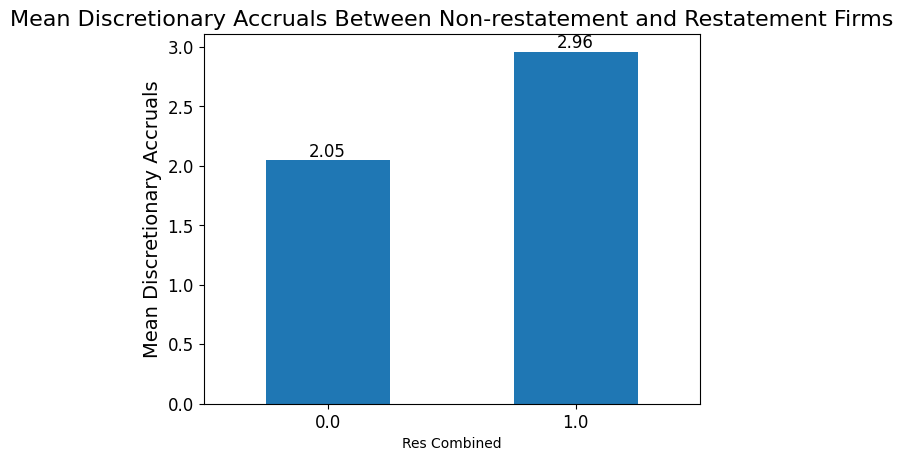

In [34]:
import matplotlib.pyplot as plt

grouped_data = FullDataJones.groupby('all_res')['discretionary_accruals'].mean()
ax = grouped_data.plot(kind='bar', rot=0, fontsize=12)

# Add labels to each bar
for i, v in enumerate(grouped_data.values):
    ax.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Res Combined', fontsize=10)
plt.ylabel('Mean Discretionary Accruals', fontsize=14)
plt.title('Mean Discretionary Accruals Between Non-restatement and Restatement Firms', fontsize=16)
plt.show()

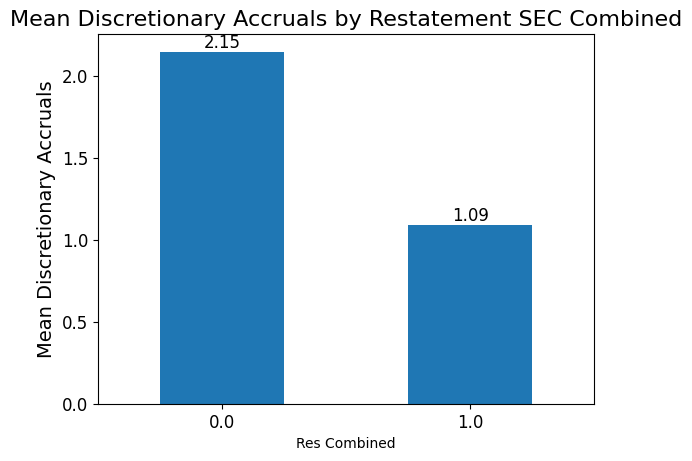

In [35]:
grouped_data = FullDataJones.groupby('res_sec_invest')['discretionary_accruals'].mean()
ax = grouped_data.plot(kind='bar', rot=0, fontsize=12)

# Add labels to each bar
for i, v in enumerate(grouped_data.values):
    ax.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Res Combined', fontsize=10)
plt.ylabel('Mean Discretionary Accruals', fontsize=14)
plt.title('Mean Discretionary Accruals by Restatement SEC Combined', fontsize=16)
plt.show()

Comments:
1. SEC investigation restatement:
An SEC investigation restatement is triggered when the SEC, a regulatory body responsible for overseeing financial markets in the United States, discovers financial reporting irregularities, accounting fraud, or other violations of securities laws in a company's financial statements. The SEC may launch an investigation into the company's accounting practices, leading to the requirement to restate its financial statements to correct the issues. The reasons for SEC investigation restatements may include:
Intentional manipulation of financial statements (e.g., revenue recognition fraud, expense manipulation, or hiding liabilities)
Violations of securities laws or regulations
Insider trading or other illegal activities related to financial reporting
2. Non-SEC investigation restatement:
A non-SEC investigation restatement occurs when a company voluntarily restates its financial statements due to errors or inaccuracies discovered internally or by external auditors. In these cases, the restatement is not a result of an SEC investigation or enforcement action. The reasons for non-SEC investigation restatements may include:
Unintentional errors in financial reporting (e.g., mistakes in accounting estimates, data entry errors, or misapplication of accounting principles)
Changes in accounting policies or standards that require the company to restate its financial statements for consistency and comparability
Discovery of material misstatements or omissions that were not previously identified
3. In general, SEC investigation restatements tend to be viewed more negatively by investors and the market than non-SEC investigation restatements, as they often involve intentional wrongdoing, legal consequences, and reputational damage. Non-SEC investigation restatements, while still concerning, are often seen as less severe, as they are typically the result of unintentional errors or changes in accounting policies.

#### Modified Jones Model

##### Calculate Accruals

In [36]:
CompIndus_JonesM_original = CompIndus[['gvkey', 'cik', 'fyear', 'sic', 'at', 'sale', 'ppent', 'rect', 'act', 'lct','dp','che', 'dlc']]

In [37]:
CompIndus_JonesM_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175578 entries, 1 to 218138
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   gvkey   175578 non-null  object 
 1   cik     134002 non-null  object 
 2   fyear   175578 non-null  float64
 3   sic     175578 non-null  Int64  
 4   at      131930 non-null  float64
 5   sale    131096 non-null  float64
 6   ppent   126906 non-null  float64
 7   rect    72313 non-null   float64
 8   act     68736 non-null   float64
 9   lct     68864 non-null   float64
 10  dp      126489 non-null  float64
 11  che     73288 non-null   float64
 12  dlc     75665 non-null   float64
dtypes: Int64(1), float64(10), object(2)
memory usage: 18.9+ MB


In [38]:
# Drop missing observations from the final sample
CompIndus_JonesM_original = CompIndus_JonesM_original.dropna()

In [39]:
CompIndus_JonesM_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59071 entries, 7 to 218137
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gvkey   59071 non-null  object 
 1   cik     59071 non-null  object 
 2   fyear   59071 non-null  float64
 3   sic     59071 non-null  Int64  
 4   at      59071 non-null  float64
 5   sale    59071 non-null  float64
 6   ppent   59071 non-null  float64
 7   rect    59071 non-null  float64
 8   act     59071 non-null  float64
 9   lct     59071 non-null  float64
 10  dp      59071 non-null  float64
 11  che     59071 non-null  float64
 12  dlc     59071 non-null  float64
dtypes: Int64(1), float64(10), object(2)
memory usage: 6.4+ MB


In [40]:
CompIndus_JonesM = CompIndus_JonesM_original.copy()

# Filter the DataFrame for years 2011 to 2018
CompIndus_JonesM = CompIndus_JonesM[(CompIndus_JonesM['fyear'] >= 2011) & (CompIndus_JonesM['fyear'] <= 2018)]

# Further filter the company by the first two digits of SIC
CompIndus_JonesM['sic2'] = CompIndus_JonesM['sic'].astype(str).str[:2].astype(int)

# Sort the DataFrame by 'gvkey' and 'fyear'
CompIndus_JonesM = CompIndus_JonesM.sort_values(by=['gvkey', 'fyear'])

# Calculate the change in current assets, change in cash, and change in current liabilities
CompIndus_JonesM['delta_ca'] = CompIndus_JonesM.groupby('gvkey')['act'].diff()
CompIndus_JonesM['delta_cash'] = CompIndus_JonesM.groupby('gvkey')['che'].diff()
CompIndus_JonesM['delta_cl'] = CompIndus_JonesM.groupby('gvkey')['lct'].diff()
CompIndus_JonesM['delta_revenue'] = CompIndus_JonesM.groupby('gvkey')['sale'].diff()
CompIndus_JonesM['delta_receivables'] = CompIndus_JonesM.groupby('gvkey')['rect'].diff()
CompIndus_JonesM['delta_dlc'] = CompIndus_JonesM.groupby('gvkey')['dlc'].diff()

# Calculate total accruals
CompIndus_JonesM['total_accruals'] = CompIndus_JonesM['delta_ca'] - CompIndus_JonesM['delta_cash'] - CompIndus_JonesM['delta_cl'] + CompIndus_JonesM['delta_dlc'] - CompIndus_JonesM['dp']

# Calculate the independent variables for the Jones model
CompIndus_JonesM['lagged_total_assets'] = CompIndus_JonesM.groupby('gvkey')['at'].shift(1)

# Drop rows with missing values in 'delta_sale', 'ppent', or 'lagged_total_assets' columns
CompIndus_JonesM = CompIndus_JonesM.dropna(subset=['delta_ca', 'delta_cash', 'delta_cl', 'delta_revenue', 'delta_receivables','ppent', 'lagged_total_assets'])

In [41]:
# Estimate the Jones model
def jonesM_regression(group):

    # Check if the group has enough observations
    if len(group) >= 2:
        
        y = group['total_accruals'] / group['lagged_total_assets']
        X = group[['delta_revenue', 'ppent', 'lagged_total_assets', 'delta_receivables']]
        X['delta_revenue minus delta_receivables'] = (X['delta_revenue'] - X['delta_receivables']) / group['lagged_total_assets']
        X['ppent'] = X['ppent'] / group['lagged_total_assets']
        X['lagged_total_assests'] = 1 / group['lagged_total_assets']
        X = sm.add_constant(X)
    
    
        # Drop rows with missing or infinite values in the independent variables
        X = X.replace([np.inf, -np.inf], np.nan).dropna()

        # Align the indices of endog (y) and exog (X)
        y = y.loc[X.index]

        model = sm.OLS(y, X, missing='drop').fit()

        group['nondiscretionary_accruals'] = model.predict(X)
        group['discretionary_accruals'] = abs(group['total_accruals'] / group['lagged_total_assets'] - group['nondiscretionary_accruals'])
        return group, model

    else:
        return group, None  # Return None for the model if there are not enough observations


CompIndus_JonesM, models = zip(*CompIndus_JonesM.groupby(['sic2', 'fyear']).apply(jonesM_regression))
CompIndus_JonesM = pd.concat(CompIndus_JonesM)

In [42]:
CompIndus_JonesM

,gvkey,cik,fyear,sic,at,sale,ppent,rect,act,lct,...,delta_ca,delta_cash,delta_cl,delta_revenue,delta_receivables,delta_dlc,total_accruals,lagged_total_assets,nondiscretionary_accruals,discretionary_accruals
138981,001186,0000002809,2012.0,1040,5255.842,1917.714,4067.456,135.860,903.269,276.668,...,81.689,9.858,22.224,95.915,-6.345,1.887,-229.490,5034.262,0.410348,0.455934
51226,001266,0000003545,2012.0,100,185.083,127.187,122.834,4.398,51.467,17.148,...,22.286,13.760,5.321,28.595,0.771,-0.012,-5.236,180.035,-0.472192,0.443109
54164,002055,0000756894,2012.0,1040,47282.000,14547.000,28717.000,675.000,5863.000,4415.000,...,-682.000,-652.000,1504.000,235.000,55.000,1652.000,-1658.000,48884.000,0.074074,0.107991
197219,002777,0001686954,2012.0,1040,12.764,0.000,11.995,0.207,0.712,0.198,...,-0.565,-0.340,-0.277,0.000,-0.224,0.000,-0.012,13.907,0.456970,0.457833
217238,002812,0000018169,2012.0,100,4229.771,4246.708,688.890,490.977,2744.691,1479.200,...,934.346,-36.999,398.830,-2977.128,-186.922,142.787,649.502,4270.071,3.314839,3.162733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47650,186166,0001492448,2018.0,9995,0.000,0.000,0.000,0.000,0.000,0.214,...,-0.002,-0.002,0.123,0.000,0.000,0.008,-0.115,0.002,-28.676384,28.823616
65658,186568,0001478682,2018.0,9995,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,-0.114,0.000,0.000,-0.041,0.073,0.000,NaN,NaN
216138,186823,0001452857,2018.0,9997,2356.059,1584.614,297.467,363.715,1092.291,669.917,...,63.729,-143.940,155.044,212.587,129.404,1.810,-25.888,2164.040,-1.865802,1.853839
191929,187627,0001470550,2018.0,9995,0.077,0.000,0.012,0.000,0.065,0.711,...,-0.036,-0.084,0.032,0.000,0.000,-0.134,-0.118,0.101,-2.499373,1.331056


##### Merge the Restatement Table to the Financial Table

In [43]:
FullDataJonesM = pd.merge(
    CompIndus_JonesM, restatements_extended_training,
    left_on=['cik', 'fyear'],
    right_on=['company_fkey', 'firm_year'],
    how='left'
)
FullDataJonesM = FullDataJonesM[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'all_res', 'res_sec_invest']]
FullDataJonesM.fillna(0, inplace=True)

FullDataJonesM = FullDataJonesM.drop_duplicates()

In [44]:
FullDataJonesM

,cik,discretionary_accruals,fyear,sic2,all_res,res_sec_invest
0,0000002809,0.455934,2012.0,10,0.0,0.0
1,0000003545,0.443109,2012.0,10,0.0,0.0
2,0000756894,0.107991,2012.0,10,0.0,0.0
3,0001686954,0.457833,2012.0,10,0.0,0.0
4,0000018169,3.162733,2012.0,10,0.0,0.0
...,...,...,...,...,...,...
35912,0001492448,28.823616,2018.0,99,0.0,0.0
35913,0001478682,0.000000,2018.0,99,1.0,0.0
35915,0001452857,1.853839,2018.0,99,0.0,0.0
35916,0001470550,1.331056,2018.0,99,0.0,0.0


#####Modeling for Modified Jones

In [45]:
# Run the linear regression using the formula notation
model = smf.ols('discretionary_accruals ~ all_res', data=FullDataJonesM).fit()

# Print the summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     discretionary_accruals   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     2.947
Date:                    Mon, 10 Apr 2023   Prob (F-statistic):             0.0860
Time:                            01:54:22   Log-Likelihood:            -1.6580e+05
No. Observations:                   35295   AIC:                         3.316e+05
Df Residuals:                       35293   BIC:                         3.316e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [46]:
# Run the linear regression using the formula notation
model = smf.ols('discretionary_accruals ~ res_sec_invest', data=FullDataJonesM).fit()

# Print the summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     discretionary_accruals   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.000
Method:                     Least Squares   F-statistic:                    0.2441
Date:                    Mon, 10 Apr 2023   Prob (F-statistic):              0.621
Time:                            01:54:22   Log-Likelihood:            -1.6581e+05
No. Observations:                   35295   AIC:                         3.316e+05
Df Residuals:                       35293   BIC:                         3.316e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Inte

##### EDA

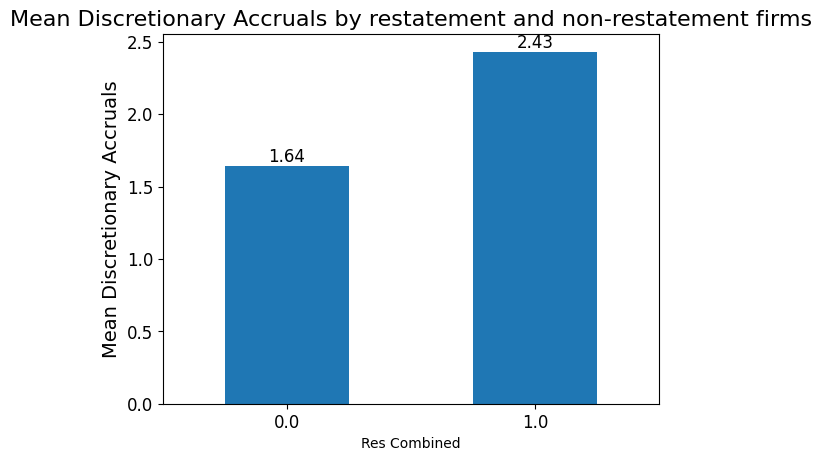

In [47]:
import matplotlib.pyplot as plt

grouped_data = FullDataJonesM.groupby('all_res')['discretionary_accruals'].mean()
ax = grouped_data.plot(kind='bar', rot=0, fontsize=12)

# Add labels to each bar
for i, v in enumerate(grouped_data.values):
    ax.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Res Combined', fontsize=10)
plt.ylabel('Mean Discretionary Accruals', fontsize=14)
plt.title('Mean Discretionary Accruals by restatement and non-restatement firms', fontsize=16)
plt.show()

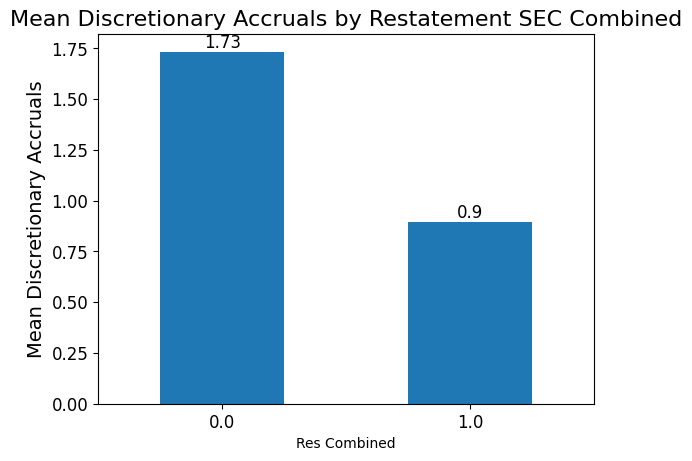

In [48]:
grouped_data = FullDataJonesM.groupby('res_sec_invest')['discretionary_accruals'].mean()
ax = grouped_data.plot(kind='bar', rot=0, fontsize=12)

# Add labels to each bar
for i, v in enumerate(grouped_data.values):
    ax.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Res Combined', fontsize=10)
plt.ylabel('Mean Discretionary Accruals', fontsize=14)
plt.title('Mean Discretionary Accruals by Restatement SEC Combined', fontsize=16)
plt.show()

#### Teoh et al Model

##### Calculate Accruals

In [49]:
CompIndus_Tea_original = CompIndus[['gvkey', 'cik', 'fyear', 'sic', 'at', 'sale', 'rect', 'che', 'act', 'lct', 'dlc']]

In [50]:
CompIndus_Tea_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175578 entries, 1 to 218138
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   gvkey   175578 non-null  object 
 1   cik     134002 non-null  object 
 2   fyear   175578 non-null  float64
 3   sic     175578 non-null  Int64  
 4   at      131930 non-null  float64
 5   sale    131096 non-null  float64
 6   rect    72313 non-null   float64
 7   che     73288 non-null   float64
 8   act     68736 non-null   float64
 9   lct     68864 non-null   float64
 10  dlc     75665 non-null   float64
dtypes: Int64(1), float64(8), object(2)
memory usage: 16.2+ MB


In [51]:
# Drop missing observations from the final sample
CompIndus_Tea_original = CompIndus_Tea_original.dropna()

In [52]:
CompIndus_Tea_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59310 entries, 7 to 218137
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gvkey   59310 non-null  object 
 1   cik     59310 non-null  object 
 2   fyear   59310 non-null  float64
 3   sic     59310 non-null  Int64  
 4   at      59310 non-null  float64
 5   sale    59310 non-null  float64
 6   rect    59310 non-null  float64
 7   che     59310 non-null  float64
 8   act     59310 non-null  float64
 9   lct     59310 non-null  float64
 10  dlc     59310 non-null  float64
dtypes: Int64(1), float64(8), object(2)
memory usage: 5.5+ MB


In [53]:
CompIndus_Tea = CompIndus_Tea_original.copy()

# Filter the DataFrame for years 2011 to 2018
CompIndus_Tea = CompIndus_Tea[(CompIndus_Tea['fyear'] >= 2011) & (CompIndus_Tea['fyear'] <= 2018)]

# Further filter the company by the first two digits of SIC
CompIndus_Tea['sic2'] = CompIndus_Tea['sic'].astype(str).str[:2].astype(int)

# Sort the DataFrame by 'gvkey' and 'fyear'
CompIndus_Tea = CompIndus_Tea.sort_values(by=['gvkey', 'fyear'])

# Calculate the change in current assets, change in cash, and change in current liabilities
CompIndus_Tea['delta_ca'] = CompIndus_Tea.groupby('gvkey')['act'].diff()
CompIndus_Tea['delta_cash'] = CompIndus_Tea.groupby('gvkey')['che'].diff()
CompIndus_Tea['delta_cl'] = CompIndus_Tea.groupby('gvkey')['lct'].diff()
CompIndus_Tea['delta_revenue'] = CompIndus_Tea.groupby('gvkey')['sale'].diff()
CompIndus_Tea['delta_receivables'] = CompIndus_Tea.groupby('gvkey')['rect'].diff()
CompIndus_Tea['delta_dlc'] = CompIndus_Tea.groupby('gvkey')['dlc'].diff()

# Calculate total accruals
CompIndus_Tea['total_current_accruals'] = CompIndus_Tea['delta_ca'] - CompIndus_Tea['delta_cash'] - CompIndus_Tea['delta_cl'] + CompIndus_Tea['delta_dlc'] 

# Calculate the independent variables for the Jones model
CompIndus_Tea['lagged_total_assets'] = CompIndus_Tea.groupby('gvkey')['at'].shift(1)

# Drop rows with missing values in 'delta_sale', 'ppent', or 'lagged_total_assets' columns
CompIndus_Tea = CompIndus_Tea.dropna(subset=['delta_ca', 'delta_cash', 'delta_cl', 'delta_revenue', 'delta_receivables', 'lagged_total_assets'])

In [54]:
# Estimate the Jones model
def TEA_regression(group):

    # Check if the group has enough observations
    if len(group) >= 2:
        
        y = group['total_current_accruals'] / group['lagged_total_assets']
        X = group[['delta_revenue', 'lagged_total_assets', 'delta_receivables']]
        X['delta_revenue minus delta_receivables'] = (X['delta_revenue'] - X['delta_receivables']) / group['lagged_total_assets']
        X['lagged_total_assests'] = 1 / group['lagged_total_assets']
        X = sm.add_constant(X)
    
    
        # Drop rows with missing or infinite values in the independent variables
        X = X.replace([np.inf, -np.inf], np.nan).dropna()

        # Align the indices of endog (y) and exog (X)
        y = y.loc[X.index]

        model = sm.OLS(y, X, missing='drop').fit()

        group['nondiscretionary_accruals'] = model.predict(X)
        group['discretionary_accruals'] = abs(group['total_current_accruals'] / group['lagged_total_assets'] - group['nondiscretionary_accruals'])
        return group, model

    else:
        return group, None  # Return None for the model if there are not enough observations


CompIndus_Tea, models = zip(*CompIndus_Tea.groupby(['sic2', 'fyear']).apply(TEA_regression))
CompIndus_Tea = pd.concat(CompIndus_Tea)

In [55]:
CompIndus_Tea

,gvkey,cik,fyear,sic,at,sale,rect,che,act,lct,...,delta_ca,delta_cash,delta_cl,delta_revenue,delta_receivables,delta_dlc,total_current_accruals,lagged_total_assets,nondiscretionary_accruals,discretionary_accruals
138981,001186,0000002809,2012.0,1040,5255.842,1917.714,135.860,376.727,903.269,276.668,...,81.689,9.858,22.224,95.915,-6.345,1.887,51.494,5034.262,0.366843,0.356615
51226,001266,0000003545,2012.0,100,185.083,127.187,4.398,16.085,51.467,17.148,...,22.286,13.760,5.321,28.595,0.771,-0.012,3.193,180.035,-0.406079,0.423815
54164,002055,0000756894,2012.0,1040,47282.000,14547.000,675.000,2093.000,5863.000,4415.000,...,-682.000,-652.000,1504.000,235.000,55.000,1652.000,118.000,48884.000,0.256319,0.253905
197219,002777,0001686954,2012.0,1040,12.764,0.000,0.207,0.500,0.712,0.198,...,-0.565,-0.340,-0.277,0.000,-0.224,0.000,0.052,13.907,0.364075,0.360336
217238,002812,0000018169,2012.0,100,4229.771,4246.708,490.977,91.579,2744.691,1479.200,...,934.346,-36.999,398.830,-2977.128,-186.922,142.787,715.302,4270.071,3.578174,3.410659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47650,186166,0001492448,2018.0,9995,0.000,0.000,0.000,0.000,0.000,0.214,...,-0.002,-0.002,0.123,0.000,0.000,0.008,-0.115,0.002,-28.423973,29.076027
65658,186568,0001478682,2018.0,9995,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,-0.114,0.000,0.000,-0.041,0.073,0.000,NaN,NaN
216138,186823,0001452857,2018.0,9997,2356.059,1584.614,363.715,348.757,1092.291,669.917,...,63.729,-143.940,155.044,212.587,129.404,1.810,54.435,2164.040,-2.404250,2.429405
191929,187627,0001470550,2018.0,9995,0.077,0.000,0.000,0.008,0.065,0.711,...,-0.036,-0.084,0.032,0.000,0.000,-0.134,-0.118,0.101,-2.945703,1.777386


##### Merge the Restatement Table to the Financial Table

In [56]:
FullDataTEA = pd.merge(
    CompIndus_Tea, restatements_extended_training,
    left_on=['cik', 'fyear'],
    right_on=['company_fkey', 'firm_year'],
    how='left'
)
FullDataTEA = FullDataTEA[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'all_res','res_sec_invest']]
FullDataTEA.fillna(0, inplace=True)

FullDataTEA = FullDataTEA.drop_duplicates()

In [57]:
FullDataTEA

,cik,discretionary_accruals,fyear,sic2,all_res,res_sec_invest
0,0000002809,0.356615,2012.0,10,0.0,0.0
1,0000003545,0.423815,2012.0,10,0.0,0.0
2,0000756894,0.253905,2012.0,10,0.0,0.0
3,0001686954,0.360336,2012.0,10,0.0,0.0
4,0000018169,3.410659,2012.0,10,0.0,0.0
...,...,...,...,...,...,...
36063,0001492448,29.076027,2018.0,99,0.0,0.0
36064,0001478682,0.000000,2018.0,99,1.0,0.0
36066,0001452857,2.429405,2018.0,99,0.0,0.0
36067,0001470550,1.777386,2018.0,99,0.0,0.0


#####Modeling for Teoh el at

In [58]:
# Run the linear regression using the formula notation
model = smf.ols('discretionary_accruals ~ all_res', data=FullDataTEA).fit()

# Print the summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     discretionary_accruals   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     2.693
Date:                    Mon, 10 Apr 2023   Prob (F-statistic):              0.101
Time:                            01:54:37   Log-Likelihood:            -1.6825e+05
No. Observations:                   35446   AIC:                         3.365e+05
Df Residuals:                       35444   BIC:                         3.365e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [59]:
# Run the linear regression using the formula notation
model = smf.ols('discretionary_accruals ~ res_sec_invest', data=FullDataTEA).fit()

# Print the summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     discretionary_accruals   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.000
Method:                     Least Squares   F-statistic:                    0.2716
Date:                    Mon, 10 Apr 2023   Prob (F-statistic):              0.602
Time:                            01:54:37   Log-Likelihood:            -1.6825e+05
No. Observations:                   35446   AIC:                         3.365e+05
Df Residuals:                       35444   BIC:                         3.365e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Inte

##### EDA

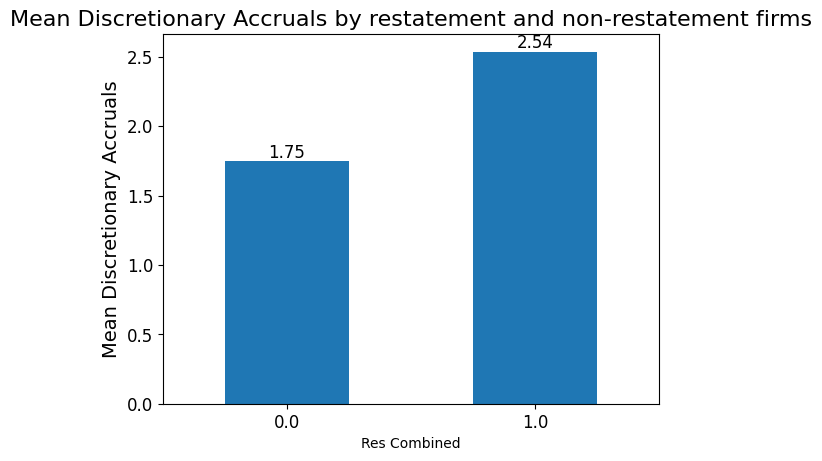

In [60]:
import matplotlib.pyplot as plt

grouped_data = FullDataTEA.groupby('all_res')['discretionary_accruals'].mean()
ax = grouped_data.plot(kind='bar', rot=0, fontsize=12)

# Add labels to each bar
for i, v in enumerate(grouped_data.values):
    ax.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Res Combined', fontsize=10)
plt.ylabel('Mean Discretionary Accruals', fontsize=14)
plt.title('Mean Discretionary Accruals by restatement and non-restatement firms', fontsize=16)
plt.show()

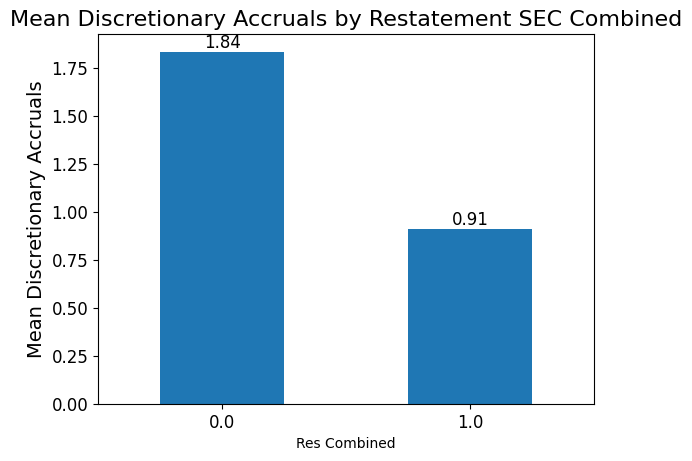

In [61]:
grouped_data = FullDataTEA.groupby('res_sec_invest')['discretionary_accruals'].mean()
ax = grouped_data.plot(kind='bar', rot=0, fontsize=12)

# Add labels to each bar
for i, v in enumerate(grouped_data.values):
    ax.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Res Combined', fontsize=10)
plt.ylabel('Mean Discretionary Accruals', fontsize=14)
plt.title('Mean Discretionary Accruals by Restatement SEC Combined', fontsize=16)
plt.show()

### Question 2

#### Base Model with Only Accruals

##### Predict All Types of Restatement

In [62]:
# Run the logistic regression using the formula notation
model = smf.logit('all_res ~ discretionary_accruals', data=FullDataJones).fit()

# Print the summary of the regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.336622
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                35675
Model:                          Logit   Df Residuals:                    35673
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:               0.0001136
Time:                        01:54:39   Log-Likelihood:                -12009.
converged:                       True   LL-Null:                       -12010.
Covariance Type:            nonrobust   LLR p-value:                   0.09860
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.1412      0.017   -123.856      0.000      -2.175      

In [63]:
# Run the logistic regression using the formula notation
model = smf.logit('all_res ~ discretionary_accruals', data=FullDataJonesM).fit()

# Print the summary of the regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.338266
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                35295
Model:                          Logit   Df Residuals:                    35293
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:               8.638e-05
Time:                        01:54:39   Log-Likelihood:                -11939.
converged:                       True   LL-Null:                       -11940.
Covariance Type:            nonrobust   LLR p-value:                    0.1509
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.1325      0.017   -123.186      0.000      -2.166      

In [64]:
# Run the logistic regression using the formula notation
model = smf.logit('all_res ~ discretionary_accruals', data=FullDataTEA).fit()

# Print the summary of the regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.337484
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                35446
Model:                          Logit   Df Residuals:                    35444
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:               8.128e-05
Time:                        01:54:39   Log-Likelihood:                -11962.
converged:                       True   LL-Null:                       -11963.
Covariance Type:            nonrobust   LLR p-value:                    0.1631
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.1364      0.017   -123.475      0.000      -2.170      

##### Predict SEC Investigation Restatement 

In [65]:
# Run the logistic regression using the formula notation
model = smf.logit('res_sec_invest ~ discretionary_accruals', data=FullDataJones).fit()

# Print the summary of the regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.041308
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         res_sec_invest   No. Observations:                35675
Model:                          Logit   Df Residuals:                    35673
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:               0.0005195
Time:                        01:54:40   Log-Likelihood:                -1473.7
converged:                       True   LL-Null:                       -1474.4
Covariance Type:            nonrobust   LLR p-value:                    0.2158
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4.9487      0.066    -75.031      0.000      -5.078     

In [66]:
# Run the logistic regression using the formula notation
model = smf.logit('res_sec_invest ~ discretionary_accruals', data=FullDataJonesM).fit()

# Print the summary of the regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.041683
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         res_sec_invest   No. Observations:                35295
Model:                          Logit   Df Residuals:                    35293
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:               0.0003963
Time:                        01:54:40   Log-Likelihood:                -1471.2
converged:                       True   LL-Null:                       -1471.8
Covariance Type:            nonrobust   LLR p-value:                    0.2801
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4.9409      0.066    -75.119      0.000      -5.070     

In [67]:
# Run the logistic regression using the formula notation
model = smf.logit('res_sec_invest ~ discretionary_accruals', data=FullDataTEA).fit()

# Print the summary of the regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.041675
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         res_sec_invest   No. Observations:                35446
Model:                          Logit   Df Residuals:                    35444
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:               0.0003844
Time:                        01:54:41   Log-Likelihood:                -1477.2
converged:                       True   LL-Null:                       -1477.8
Covariance Type:            nonrobust   LLR p-value:                    0.2865
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4.9427      0.065    -75.683      0.000      -5.071     

#### Add Additional Variables

###### Prior Stock Performance
Get the annual prior stock performance by calculating the annual stock return from CRSP database.

In [68]:
# Get the firm level factors
firm_level_factors = db.raw_sql("""
                      SELECT PERMNO, date, PRC, RET
                      FROM crsp.msf
                      WHERE date >= '2011-01-01' AND date <= '2021-12-31'
                      """) 
firm_level_factors

,permno,date,prc,ret
0,10001.0,2011-01-31,10.780000,0.028992
1,10001.0,2011-02-28,10.980000,0.022727
2,10001.0,2011-03-31,11.730000,0.072404
3,10001.0,2011-04-29,11.230000,-0.038789
4,10001.0,2011-05-31,11.500000,0.028050
...,...,...,...,...
479156,93436.0,2021-08-31,735.719971,0.070605
479157,93436.0,2021-09-30,775.479980,0.054042
479158,93436.0,2021-10-29,1114.000000,0.436530
479159,93436.0,2021-11-30,1144.760010,0.027612


In [69]:
# Convert the 'date' column to datetime format
firm_level_factors['date'] = pd.to_datetime(firm_level_factors['date'])

# Set the 'date' column as the index
firm_level_factors.set_index('date', inplace=True)

# Group the data by 'PERMNO' and resample yearly, then calculate the annual return
annual_returns = firm_level_factors.groupby('permno').resample('Y', level=0)['ret'].apply(lambda x: np.prod(1 + x) - 1).reset_index()

# Rename the columns for clarity
annual_returns.columns = ['PERMNO', 'date', 'annual_return']

# Calculate prior year's annual return
annual_returns['prior_year_return'] = annual_returns.groupby('PERMNO')['annual_return'].shift(1)

# Change the 'date' column to the beginning of each year
annual_returns['date'] = annual_returns['date'].dt.to_period('Y').dt.to_timestamp()


In [70]:
# Get the firm level factors
mapping_data = db.raw_sql("""
                      SELECT l.LPERMNO, l.GVKEY, c.CIK
                      FROM crsp.ccmxpf_linktable AS l
                      LEFT JOIN comp.company AS c ON l.GVKEY = c.GVKEY
                      WHERE l.LINKPRIM IN ('P', 'C') AND l.LINKTYPE IN ('LU', 'LC')
                      """) 
mapping_data

,lpermno,gvkey,cik
0,25881.0,001000,None
1,10015.0,001001,0000723576
2,10023.0,001002,0001306124
3,10031.0,001003,0000730052
4,54594.0,001004,0000001750
...,...,...,...
32185,15642.0,349972,0001857044
32186,23514.0,349994,0001892500
32187,22205.0,350681,0001867325
32188,16161.0,351038,0001671502


In [71]:
# Merge prior_annual_returns with mapping_data to get the cik
prior_annual_returns = pd.merge(annual_returns, mapping_data, left_on='PERMNO', right_on = 'lpermno', how='left')

In [72]:
# Select the required columns
prior_annual_returns = prior_annual_returns[['cik', 'date', 'prior_year_return']]

# Filter the period
prior_annual_returns = prior_annual_returns[prior_annual_returns['date'] >= '2012-01-01'] 

# Change the type of the year
prior_annual_returns['date'] = prior_annual_returns['date'].dt.year.astype(float)

# Merge with the FullDataJones 
FullDataJones_w_par = pd.merge(FullDataJones, prior_annual_returns, left_on=['cik', 'fyear'], right_on=['cik', 'date'], how='left')

# Merge with the FullDataJonesM 
FullDataJonesM_w_par = pd.merge(FullDataJonesM, prior_annual_returns, left_on=['cik', 'fyear'], right_on=['cik', 'date'], how='left')

# Merge with the FullDataTEA 
FullDataTEA_w_par = pd.merge(FullDataTEA, prior_annual_returns, left_on=['cik', 'fyear'], right_on=['cik', 'date'], how='left')

<ipython-input-72-92c868fca583>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_annual_returns['date'] = prior_annual_returns['date'].dt.year.astype(float)


###### Market-based Incentives

In [73]:
FullDataJones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35675 entries, 0 to 36297
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cik                     35675 non-null  object 
 1   discretionary_accruals  35675 non-null  float64
 2   fyear                   35675 non-null  float64
 3   sic2                    35675 non-null  int64  
 4   res_sec_invest          35675 non-null  float64
 5   all_res                 35675 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.9+ MB


In [74]:
# Get the Market-based Incentives factors
market_data = db.raw_sql("""
                      SELECT DISTINCT cik, fyear, mkvalt, epsfx, ceq, dltt, dlc, at, ni, seq
                      FROM comp.funda
                      WHERE fyear >= EXTRACT(YEAR FROM DATE '2012-01-01') AND fyear <= EXTRACT(YEAR FROM DATE '2021-12-31')
                      AND cik != 'None'
                      """) 
market_data

,cik,fyear,mkvalt,epsfx,ceq,dltt,dlc,at,ni,seq
0,0001537028,2019.0,75.9970,-16.11,NaN,136.190,NaN,517.001,-60.788,331.596
1,0001548621,2012.0,NaN,NaN,NaN,558.125,NaN,1169.782,15.020,235.471
2,0001138724,2015.0,2.5314,-0.14,NaN,0.213,NaN,0.397,-4.287,-4.129
3,0001533924,2018.0,192.9834,2.09,NaN,294.000,NaN,836.843,54.609,416.558
4,0001697532,2017.0,NaN,-0.25,-3.961,0.000,0.000,3.286,-4.282,2.293
...,...,...,...,...,...,...,...,...,...,...
156788,0001341621,2020.0,5322.2790,-0.20,NaN,6968.608,NaN,15267.708,-64.780,7734.973
156789,0000877463,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156790,0001650575,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156791,0001538263,2012.0,NaN,0.21,172.485,16.992,7.297,1720.056,4.527,172.485


In [75]:
# Calculate the price-to-earnings ratio
market_data['pe_ratio'] = market_data['mkvalt'] / market_data['epsfx']

# Calculate the book-to-market ratio
market_data['bm_ratio'] = market_data['ceq'] / market_data['mkvalt']

# Calculate the leverage ratio
market_data['leverage_ratio'] = (market_data['dltt'] + market_data['dlc']) / market_data['at']

# Calculate the size
market_data['size'] = np.log(market_data['at'])

# Calculate the profitability (ROA and ROE)
market_data['roa'] = market_data['ni'] / market_data['at']
market_data['roe'] = market_data['ni'] / market_data['seq']

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [76]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156793 entries, 0 to 156792
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   cik             156793 non-null  object 
 1   fyear           156793 non-null  float64
 2   mkvalt          119244 non-null  float64
 3   epsfx           124792 non-null  float64
 4   ceq             86218 non-null   float64
 5   dltt            138687 non-null  float64
 6   dlc             87101 non-null   float64
 7   at              140819 non-null  float64
 8   ni              130086 non-null  float64
 9   seq             141698 non-null  float64
 10  pe_ratio        103809 non-null  float64
 11  bm_ratio        68042 non-null   float64
 12  leverage_ratio  86661 non-null   float64
 13  size            140819 non-null  float64
 14  roa             128371 non-null  float64
 15  roe             129263 non-null  float64
dtypes: float64(15), object(1)
memory usage: 19.1+ MB


###### Merge with Accruals Predicted by Jones

In [77]:
market_data = market_data[['cik', 'fyear', 'pe_ratio', 'bm_ratio', 'leverage_ratio', 'size', 'roa', 'roe']]
FullDataJones_w_par_mbi = pd.merge(
    FullDataJones_w_par, market_data, 
    on=['cik', 'fyear'], 
    how='left')

# Drop missing and infinite observations from the final sample
FullDataJones_w_par_mbi = FullDataJones_w_par_mbi.replace([np.inf, -np.inf], np.nan).dropna(subset=['pe_ratio', 'bm_ratio', 'leverage_ratio', 'size', 'roa', 'roe'])

FullDataJones_w_par_mbi

,cik,discretionary_accruals,fyear,sic2,res_sec_invest,all_res,date,prior_year_return,pe_ratio,bm_ratio,leverage_ratio,size,roa,roe
0,0000002809,0.548313,2012.0,10,0.0,0.0,2012.0,-0.521414,4988.163425,0.377713,0.162688,8.567095,0.059156,0.091172
2,0000003545,0.499379,2012.0,10,0.0,0.0,2012.0,-0.181531,91.500159,0.555356,0.215579,5.220804,0.099896,0.144959
5,0000756894,0.101563,2012.0,10,0.0,0.0,2012.0,-0.140588,-53104.228939,0.623274,0.294890,10.763885,-0.014065,-0.030442
6,0001686954,0.550042,2012.0,10,0.0,0.0,NaN,NaN,-369.310000,3.402562,0.000000,2.546629,-0.087668,-0.089050
10,0000215466,0.580126,2012.0,10,0.0,0.0,2012.0,-0.116398,4115.580000,0.989141,0.018453,8.077572,0.015111,0.022143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71456,0001689382,0.079972,2018.0,99,0.0,0.0,NaN,NaN,-178.410256,-1.028959,0.695919,6.590688,-0.027743,0.282212
71463,0001517179,11.321040,2018.0,99,0.0,0.0,NaN,NaN,1.104754,-1.549191,2.000000,-2.273026,17.427184,-1.719349
71464,0001405660,1.831714,2018.0,99,0.0,0.0,NaN,NaN,-0.208696,-1.421296,56.285714,-4.961845,-64.714286,0.737785
71474,0001452857,0.701833,2018.0,99,0.0,0.0,2018.0,0.261290,-271.151680,1.521365,0.281117,7.764746,-0.013838,-0.063229


In [78]:
FullDataJones_w_par_mbi.corr()

,discretionary_accruals,fyear,sic2,res_sec_invest,all_res,date,prior_year_return,pe_ratio,bm_ratio,leverage_ratio,size,roa,roe
discretionary_accruals,1.000000,0.004522,-0.007310,-0.002371,0.015511,0.010015,0.004552,-0.000554,-0.001505,0.150131,-0.102862,-0.089381,0.000598
fyear,0.004522,1.000000,-0.006953,-0.026620,-0.077005,1.000000,0.049129,-0.003106,-0.005629,0.009619,0.030309,0.003613,-0.012260
sic2,-0.007310,-0.006953,1.000000,0.009757,0.061531,-0.005776,0.040489,-0.008665,-0.007047,-0.000779,0.056812,-0.000769,0.004055
res_sec_invest,-0.002371,-0.026620,0.009757,1.000000,0.245030,-0.027313,-0.009140,-0.000405,-0.000436,0.002063,0.024943,-0.004305,0.000502
all_res,0.015511,-0.077005,0.061531,0.245030,1.000000,-0.085548,-0.007134,0.003776,-0.001924,-0.002055,0.070376,-0.004142,-0.022081
date,0.010015,1.000000,-0.005776,-0.027313,-0.085548,1.000000,0.049129,0.005849,-0.008088,0.008044,0.024448,-0.004896,-0.014441
prior_year_return,0.004552,0.049129,0.040489,-0.009140,-0.007134,0.049129,1.000000,0.006766,-0.002972,-0.004570,0.106758,0.010875,-0.000120
pe_ratio,-0.000554,-0.003106,-0.008665,-0.000405,0.003776,0.005849,0.006766,1.000000,-0.000038,-0.000264,0.028729,0.000233,0.000135
bm_ratio,-0.001505,-0.005629,-0.007047,-0.000436,-0.001924,-0.008088,-0.002972,-0.000038,1.000000,-0.000993,0.005755,0.001054,0.000047
leverage_ratio,0.150131,0.009619,-0.000779,0.002063,-0.002055,0.008044,-0.004570,-0.000264,-0.000993,1.000000,-0.088304,-0.117278,0.000227


In [79]:
# Run the logistic regression using the formula notation
full_model_jones_all_res = smf.logit('all_res ~ discretionary_accruals + fyear + prior_year_return + pe_ratio + bm_ratio + size + roa + roe + sic2', data=FullDataJones_w_par_mbi).fit()

# Print the summary of the regression results
print(full_model_jones_all_res.summary())

Optimization terminated successfully.
         Current function value: 0.383040
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                22026
Model:                          Logit   Df Residuals:                    22016
Method:                           MLE   Df Model:                            9
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                 0.01537
Time:                        01:55:49   Log-Likelihood:                -8436.8
converged:                       True   LL-Null:                       -8568.6
Covariance Type:            nonrobust   LLR p-value:                 1.426e-51
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                259.0409     20.604     12.572      0.000     218.658     

In [80]:
# Run the logistic regression using the formula notation
filtered_model_jones_all_res = smf.logit('all_res ~ discretionary_accruals + prior_year_return + size + sic2', data=FullDataJones_w_par_mbi).fit()

# Print the summary of the regression results
print(filtered_model_jones_all_res.summary())

Optimization terminated successfully.
         Current function value: 0.386998
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                22026
Model:                          Logit   Df Residuals:                    22021
Method:                           MLE   Df Model:                            4
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.005201
Time:                        01:55:49   Log-Likelihood:                -8524.0
converged:                       True   LL-Null:                       -8568.6
Covariance Type:            nonrobust   LLR p-value:                 2.015e-18
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.5312      0.076    -33.404      0.000      -2.680      

In [81]:
FullDataJones_w_par_mbi['predicted_probabilities'] = filtered_model_jones_all_res.predict(FullDataJones_w_par_mbi)
threshold = 0.5
FullDataJones_w_par_mbi['predicted_outcomes'] = (FullDataJones_w_par_mbi['predicted_probabilities'] > threshold).astype(int)
correct_predictions = (FullDataJones_w_par_mbi['predicted_outcomes'] == FullDataJones_w_par_mbi['all_res']).sum()
total_predictions = len(FullDataJones_w_par_mbi)
accuracy = correct_predictions / total_predictions
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 88.73%


In [82]:
# Run the logistic regression using the formula notation
filtered_model_jones_all_res = smf.logit('all_res ~ discretionary_accruals + prior_year_return + size + C(sic2)', data=FullDataJones_w_par_mbi).fit()

# Print the summary of the regression results
print(filtered_model_jones_all_res.summary())

         Current function value: 0.380535
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                22026
Model:                          Logit   Df Residuals:                    21969
Method:                           MLE   Df Model:                           56
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                 0.02181
Time:                        01:55:50   Log-Likelihood:                -8381.7
converged:                      False   LL-Null:                       -8568.6
Covariance Type:            nonrobust   LLR p-value:                 1.545e-48
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.0909      0.170    -18.161      0.000      -3.424      -2.757
C(sic2)[T.12]              1.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [83]:
# Run the logistic regression using the formula notation
full_model_jones_sec_res = smf.logit('res_sec_invest ~ discretionary_accruals + prior_year_return + pe_ratio + bm_ratio + size + roa + roe + sic2', data=FullDataJones_w_par_mbi).fit()

# Print the summary of the regression results
print(full_model_jones_sec_res.summary())

Optimization terminated successfully.
         Current function value: 0.051485
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         res_sec_invest   No. Observations:                22026
Model:                          Logit   Df Residuals:                    22017
Method:                           MLE   Df Model:                            8
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.004745
Time:                        01:55:51   Log-Likelihood:                -1134.0
converged:                       True   LL-Null:                       -1139.4
Covariance Type:            nonrobust   LLR p-value:                    0.2126
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -5.3355      0.275    -19.415      0.000      -5.874     

In [84]:
# Run the logistic regression using the formula notation
filtered_model_jones_sec_res = smf.logit('res_sec_invest ~ discretionary_accruals + prior_year_return + pe_ratio + bm_ratio + size + roa + roe + sic2', data=FullDataJones_w_par_mbi).fit()

# Print the summary of the regression results
print(filtered_model_jones_sec_res.summary())

Optimization terminated successfully.
         Current function value: 0.051485
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         res_sec_invest   No. Observations:                22026
Model:                          Logit   Df Residuals:                    22017
Method:                           MLE   Df Model:                            8
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.004745
Time:                        01:55:51   Log-Likelihood:                -1134.0
converged:                       True   LL-Null:                       -1139.4
Covariance Type:            nonrobust   LLR p-value:                    0.2126
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -5.3355      0.275    -19.415      0.000      -5.874     

###### Merge with Accruals Predicted by Modified Jones

In [85]:
market_data = market_data[['cik', 'fyear', 'pe_ratio', 'bm_ratio', 'leverage_ratio', 'size', 'roa', 'roe']]
FullDataJonesM_w_par_mbi = pd.merge(
    FullDataJonesM_w_par, market_data, 
    on=['cik', 'fyear'], 
    how='left')

# Drop missing and infinite observations from the final sample
FullDataJonesM_w_par_mbi = FullDataJonesM_w_par_mbi.replace([np.inf, -np.inf], np.nan).dropna(subset=['pe_ratio', 'bm_ratio', 'leverage_ratio', 'size', 'roa', 'roe'])

FullDataJonesM_w_par_mbi

,cik,discretionary_accruals,fyear,sic2,all_res,res_sec_invest,date,prior_year_return,pe_ratio,bm_ratio,leverage_ratio,size,roa,roe
0,0000002809,0.455934,2012.0,10,0.0,0.0,2012.0,-0.521414,4988.163425,0.377713,0.162688,8.567095,0.059156,0.091172
2,0000003545,0.443109,2012.0,10,0.0,0.0,2012.0,-0.181531,91.500159,0.555356,0.215579,5.220804,0.099896,0.144959
5,0000756894,0.107991,2012.0,10,0.0,0.0,2012.0,-0.140588,-53104.228939,0.623274,0.294890,10.763885,-0.014065,-0.030442
6,0001686954,0.457833,2012.0,10,0.0,0.0,NaN,NaN,-369.310000,3.402562,0.000000,2.546629,-0.087668,-0.089050
10,0000215466,0.749450,2012.0,10,0.0,0.0,2012.0,-0.116398,4115.580000,0.989141,0.018453,8.077572,0.015111,0.022143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70774,0001689382,2.328592,2018.0,99,0.0,0.0,NaN,NaN,-178.410256,-1.028959,0.695919,6.590688,-0.027743,0.282212
70781,0001517179,15.765774,2018.0,99,0.0,0.0,NaN,NaN,1.104754,-1.549191,2.000000,-2.273026,17.427184,-1.719349
70782,0001405660,3.921823,2018.0,99,0.0,0.0,NaN,NaN,-0.208696,-1.421296,56.285714,-4.961845,-64.714286,0.737785
70792,0001452857,1.853839,2018.0,99,0.0,0.0,2018.0,0.261290,-271.151680,1.521365,0.281117,7.764746,-0.013838,-0.063229


In [86]:
FullDataJonesM_w_par_mbi.corr()

,discretionary_accruals,fyear,sic2,all_res,res_sec_invest,date,prior_year_return,pe_ratio,bm_ratio,leverage_ratio,size,roa,roe
discretionary_accruals,1.000000,-0.001958,-0.002027,0.014370,-0.002063,-0.001076,0.004922,-0.000350,-0.001415,0.086761,-0.086442,-0.077278,0.000564
fyear,-0.001958,1.000000,-0.007883,-0.077103,-0.026793,1.000000,0.049197,-0.003060,-0.005656,0.009200,0.030813,0.003584,-0.012354
sic2,-0.002027,-0.007883,1.000000,0.058695,0.009082,-0.005667,0.041053,-0.008863,-0.007130,-0.000864,0.050797,-0.000995,0.003810
all_res,0.014370,-0.077103,0.058695,1.000000,0.245230,-0.085149,-0.007696,0.003752,-0.001940,-0.001984,0.068839,-0.004209,-0.022034
res_sec_invest,-0.002063,-0.026793,0.009082,0.245230,1.000000,-0.027345,-0.009108,-0.000420,-0.000440,0.002078,0.024405,-0.004321,0.000528
date,-0.001076,1.000000,-0.005667,-0.085149,-0.027345,1.000000,0.049197,0.005853,-0.008105,0.008064,0.024111,-0.004819,-0.014492
prior_year_return,0.004922,0.049197,0.041053,-0.007696,-0.009108,0.049197,1.000000,0.006854,-0.002978,-0.004534,0.106891,0.010920,-0.000098
pe_ratio,-0.000350,-0.003060,-0.008863,0.003752,-0.000420,0.005853,0.006854,1.000000,-0.000039,-0.000264,0.028840,0.000234,0.000140
bm_ratio,-0.001415,-0.005656,-0.007130,-0.001940,-0.000440,-0.008105,-0.002978,-0.000039,1.000000,-0.000992,0.005754,0.001054,0.000049
leverage_ratio,0.086761,0.009200,-0.000864,-0.001984,0.002078,0.008064,-0.004534,-0.000264,-0.000992,1.000000,-0.087998,-0.117290,0.000230


In [87]:
# Run the logistic regression using the formula notation
full_model_jonesM_all_res = smf.logit('all_res ~ discretionary_accruals + prior_year_return + pe_ratio + bm_ratio + size + roa + roe + sic2', data=FullDataJonesM_w_par_mbi).fit()

# Print the summary of the regression results
print(full_model_jonesM_all_res.summary())

Optimization terminated successfully.
         Current function value: 0.386841
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                21959
Model:                          Logit   Df Residuals:                    21950
Method:                           MLE   Df Model:                            8
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.006439
Time:                        01:55:52   Log-Likelihood:                -8494.6
converged:                       True   LL-Null:                       -8549.7
Covariance Type:            nonrobust   LLR p-value:                 3.621e-20
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.5619      0.077    -33.433      0.000      -2.712      

In [88]:
# Run the logistic regression using the formula notation
filtered_model_jonesM_all_res = smf.logit('all_res ~ discretionary_accruals + prior_year_return + size + sic2 + roa', data=FullDataJonesM_w_par_mbi).fit()

# Print the summary of the regression results
print(filtered_model_jonesM_all_res.summary())

Optimization terminated successfully.
         Current function value: 0.387049
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                21959
Model:                          Logit   Df Residuals:                    21953
Method:                           MLE   Df Model:                            5
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.005904
Time:                        01:55:52   Log-Likelihood:                -8499.2
converged:                       True   LL-Null:                       -8549.7
Covariance Type:            nonrobust   LLR p-value:                 3.327e-20
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.5571      0.077    -33.423      0.000      -2.707      

In [89]:
# Run the logistic regression using the formula notation
full_model_jonesM_sec_res = smf.logit('res_sec_invest ~ discretionary_accruals + prior_year_return + pe_ratio + bm_ratio + size + roa + roe + sic2', data=FullDataJonesM_w_par_mbi).fit()

# Print the summary of the regression results
print(full_model_jonesM_sec_res.summary())

Optimization terminated successfully.
         Current function value: 0.051618
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         res_sec_invest   No. Observations:                21959
Model:                          Logit   Df Residuals:                    21950
Method:                           MLE   Df Model:                            8
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.004671
Time:                        01:55:52   Log-Likelihood:                -1133.5
converged:                       True   LL-Null:                       -1138.8
Covariance Type:            nonrobust   LLR p-value:                    0.2230
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -5.3283      0.276    -19.272      0.000      -5.870     

In [90]:
# Run the logistic regression using the formula notation
filtered_model_jonesM_sec_res = smf.logit('res_sec_invest ~ discretionary_accruals + prior_year_return + size', data=FullDataJonesM_w_par_mbi).fit()

# Print the summary of the regression results
print(filtered_model_jonesM_sec_res.summary())

Optimization terminated successfully.
         Current function value: 0.051624
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:         res_sec_invest   No. Observations:                21959
Model:                          Logit   Df Residuals:                    21955
Method:                           MLE   Df Model:                            3
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.004559
Time:                        01:55:52   Log-Likelihood:                -1133.6
converged:                       True   LL-Null:                       -1138.8
Covariance Type:            nonrobust   LLR p-value:                   0.01558
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -5.2783      0.227    -23.229      0.000      -5.724      

###### Merge with Accruals Predicted by Teoh et al

In [91]:
market_data = market_data[['cik', 'fyear', 'pe_ratio', 'bm_ratio', 'leverage_ratio', 'size', 'roa', 'roe']]
FullDataTEA_w_par_mbi = pd.merge(
    FullDataTEA_w_par, market_data, 
    on=['cik', 'fyear'], 
    how='left')

# Drop missing and infinite observations from the final sample
FullDataTEA_w_par_mbi = FullDataTEA_w_par_mbi.replace([np.inf, -np.inf], np.nan).dropna(subset=['pe_ratio', 'bm_ratio', 'leverage_ratio', 'size', 'roa', 'roe'])

FullDataTEA_w_par_mbi

,cik,discretionary_accruals,fyear,sic2,all_res,res_sec_invest,date,prior_year_return,pe_ratio,bm_ratio,leverage_ratio,size,roa,roe
0,0000002809,0.356615,2012.0,10,0.0,0.0,2012.0,-0.521414,4988.163425,0.377713,0.162688,8.567095,0.059156,0.091172
2,0000003545,0.423815,2012.0,10,0.0,0.0,2012.0,-0.181531,91.500159,0.555356,0.215579,5.220804,0.099896,0.144959
5,0000756894,0.253905,2012.0,10,0.0,0.0,2012.0,-0.140588,-53104.228939,0.623274,0.294890,10.763885,-0.014065,-0.030442
6,0001686954,0.360336,2012.0,10,0.0,0.0,NaN,NaN,-369.310000,3.402562,0.000000,2.546629,-0.087668,-0.089050
10,0000215466,0.614476,2012.0,10,0.0,0.0,2012.0,-0.116398,4115.580000,0.989141,0.018453,8.077572,0.015111,0.022143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71065,0001689382,2.414089,2018.0,99,0.0,0.0,NaN,NaN,-178.410256,-1.028959,0.695919,6.590688,-0.027743,0.282212
71072,0001517179,14.605955,2018.0,99,0.0,0.0,NaN,NaN,1.104754,-1.549191,2.000000,-2.273026,17.427184,-1.719349
71073,0001405660,2.835240,2018.0,99,0.0,0.0,NaN,NaN,-0.208696,-1.421296,56.285714,-4.961845,-64.714286,0.737785
71083,0001452857,2.429405,2018.0,99,0.0,0.0,2018.0,0.261290,-271.151680,1.521365,0.281117,7.764746,-0.013838,-0.063229


In [92]:
FullDataTEA_w_par_mbi.corr()

,discretionary_accruals,fyear,sic2,all_res,res_sec_invest,date,prior_year_return,pe_ratio,bm_ratio,leverage_ratio,size,roa,roe
discretionary_accruals,1.000000,-0.004537,-0.003872,0.013621,-0.002085,-0.000216,0.004913,-0.000708,-0.001368,0.084454,-0.090530,-0.079762,0.000529
fyear,-0.004537,1.000000,-0.007602,-0.076763,-0.026812,1.000000,0.049292,-0.003009,-0.005672,0.009167,0.031556,0.003583,-0.012336
sic2,-0.003872,-0.007602,1.000000,0.057908,0.008724,-0.005007,0.041047,-0.008895,-0.007144,-0.000914,0.051473,-0.000965,0.003807
all_res,0.013621,-0.076763,0.057908,1.000000,0.245721,-0.084827,-0.007607,0.003781,-0.001927,-0.001967,0.069245,-0.004222,-0.022029
res_sec_invest,-0.002085,-0.026812,0.008724,0.245721,1.000000,-0.027413,-0.008875,-0.000413,-0.000438,0.002071,0.024632,-0.004308,0.000529
date,-0.000216,1.000000,-0.005007,-0.084827,-0.027413,1.000000,0.049292,0.006004,-0.008073,0.007357,0.025656,-0.004002,-0.014486
prior_year_return,0.004913,0.049292,0.041047,-0.007607,-0.008875,0.049292,1.000000,0.006819,-0.002974,-0.004634,0.106959,0.011051,-0.000102
pe_ratio,-0.000708,-0.003009,-0.008895,0.003781,-0.000413,0.006004,0.006819,1.000000,-0.000038,-0.000263,0.028739,0.000232,0.000140
bm_ratio,-0.001368,-0.005672,-0.007144,-0.001927,-0.000438,-0.008073,-0.002974,-0.000038,1.000000,-0.000992,0.005749,0.001054,0.000049
leverage_ratio,0.084454,0.009167,-0.000914,-0.001967,0.002071,0.007357,-0.004634,-0.000263,-0.000992,1.000000,-0.087815,-0.117291,0.000230


In [93]:
# Run the logistic regression using the formula notation
full_model_TEA_all_res = smf.logit('all_res ~ discretionary_accruals + prior_year_return + pe_ratio + bm_ratio + size + roa + roe + sic2', data=FullDataTEA_w_par_mbi).fit()

# Print the summary of the regression results
print(full_model_TEA_all_res.summary())

Optimization terminated successfully.
         Current function value: 0.386540
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                22004
Model:                          Logit   Df Residuals:                    21995
Method:                           MLE   Df Model:                            8
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.006354
Time:                        01:55:53   Log-Likelihood:                -8505.4
converged:                       True   LL-Null:                       -8559.8
Covariance Type:            nonrobust   LLR p-value:                 6.805e-20
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.5617      0.076    -33.493      0.000      -2.712      

In [94]:
# Run the logistic regression using the formula notation
filtered_model_TEA_all_res = smf.logit('all_res ~ discretionary_accruals + prior_year_return + size + sic2 + roa', data=FullDataTEA_w_par_mbi).fit()

# Print the summary of the regression results
print(filtered_model_TEA_all_res.summary())

Optimization terminated successfully.
         Current function value: 0.386748
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                22004
Model:                          Logit   Df Residuals:                    21998
Method:                           MLE   Df Model:                            5
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.005819
Time:                        01:55:53   Log-Likelihood:                -8510.0
converged:                       True   LL-Null:                       -8559.8
Covariance Type:            nonrobust   LLR p-value:                 6.371e-20
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.5569      0.076    -33.484      0.000      -2.707      

In [95]:
# Run the logistic regression using the formula notation
full_model_TEA_sec_res = smf.logit('res_sec_invest ~ discretionary_accruals + prior_year_return + pe_ratio + bm_ratio + size + roa + roe + sic2', data=FullDataTEA_w_par_mbi).fit()

# Print the summary of the regression results
print(full_model_TEA_sec_res.summary())

Optimization terminated successfully.
         Current function value: 0.051746
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         res_sec_invest   No. Observations:                22004
Model:                          Logit   Df Residuals:                    21995
Method:                           MLE   Df Model:                            8
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.004625
Time:                        01:55:53   Log-Likelihood:                -1138.6
converged:                       True   LL-Null:                       -1143.9
Covariance Type:            nonrobust   LLR p-value:                    0.2265
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -5.3139      0.276    -19.284      0.000      -5.854     

In [96]:
# Run the logistic regression using the formula notation
filtered_model_TEA_res_sec = smf.logit('res_sec_invest ~ discretionary_accruals + prior_year_return + size', data=FullDataTEA_w_par_mbi).fit()

# Print the summary of the regression results
print(filtered_model_TEA_res_sec.summary())

Optimization terminated successfully.
         Current function value: 0.051751
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:         res_sec_invest   No. Observations:                22004
Model:                          Logit   Df Residuals:                    22000
Method:                           MLE   Df Model:                            3
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                0.004534
Time:                        01:55:54   Log-Likelihood:                -1138.7
converged:                       True   LL-Null:                       -1143.9
Covariance Type:            nonrobust   LLR p-value:                   0.01564
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -5.2757      0.227    -23.282      0.000      -5.720      

### Question 3

#### Jones Model

##### Calculate Accruals

In [164]:
CompIndus_Jones_predict = CompIndus_Jones_original.copy()

# Filter the DataFrame for years 2018 to 2021
CompIndus_Jones_predict = CompIndus_Jones_predict[(CompIndus_Jones_predict['fyear'] >= 2018) & (CompIndus_Jones_predict['fyear'] <= 2021)]

# Further filter the company by the first two digits of SIC
CompIndus_Jones_predict['sic2'] = CompIndus_Jones_predict['sic'].astype(str).str[:2].astype(int)

# Sort the DataFrame by 'gvkey' and 'fyear'
CompIndus_Jones_predict = CompIndus_Jones_predict.sort_values(by=['gvkey', 'fyear'])

# Calculate the change in current assets, change in cash, and change in current liabilities
CompIndus_Jones_predict['delta_ca'] = CompIndus_Jones_predict.groupby('gvkey')['act'].diff()
CompIndus_Jones_predict['delta_cash'] = CompIndus_Jones_predict.groupby('gvkey')['che'].diff()
CompIndus_Jones_predict['delta_cl'] = CompIndus_Jones_predict.groupby('gvkey')['lct'].diff()
CompIndus_Jones_predict['delta_revenue'] = CompIndus_Jones_predict.groupby('gvkey')['sale'].diff()

# Calculate total accruals
CompIndus_Jones_predict['total_accruals'] = CompIndus_Jones_predict['delta_ca'] - CompIndus_Jones_predict['delta_cash'] - CompIndus_Jones_predict['delta_cl'] - CompIndus_Jones_predict['dp']

# Calculate the independent variables for the Jones model
CompIndus_Jones_predict['lagged_total_assets'] = CompIndus_Jones_predict.groupby('gvkey')['at'].shift(1)

# Drop rows with missing values in 'delta_sale', 'ppent', or 'lagged_total_assets' columns
CompIndus_Jones_predict = CompIndus_Jones_predict.dropna(subset=['delta_ca', 'delta_cash', 'delta_cl', 'delta_revenue', 'ppent', 'lagged_total_assets'])

In [165]:
# Apply Jones regression to predict
CompIndus_Jones_predict, models = zip(*CompIndus_Jones_predict.groupby(['sic2', 'fyear']).apply(jones_regression))
CompIndus_Jones_predict = pd.concat(CompIndus_Jones_predict)

In [166]:
CompIndus_Jones_predict

,gvkey,cik,fyear,sic,at,sale,ppent,act,lct,dp,che,sic2,delta_ca,delta_cash,delta_cl,delta_revenue,total_accruals,lagged_total_assets,nondiscretionary_accruals,discretionary_accruals
88118,001186,0000002809,2019.0,1040,8789.885,2494.892,7003.665,1193.560,775.638,554.576,414.154,10,121.108,29.716,414.189,303.671,-877.373,7852.843,-3.872928,3.761202
38688,001266,0000003545,2019.0,100,417.388,122.251,345.648,61.977,28.951,13.924,18.630,10,-10.263,-6.630,7.453,40.970,-25.010,423.422,-6.575710,6.516644
13757,002055,0000756894,2019.0,1040,44392.000,9717.000,24428.000,6887.000,2376.000,2112.000,3314.000,10,2909.000,1743.000,708.000,2474.000,-1654.000,22631.000,-8.120053,8.046968
83979,002777,0001686954,2019.0,1040,3.382,0.000,1.775,1.572,0.132,0.000,1.562,10,0.603,0.606,-0.118,0.000,0.115,2.341,-1.268364,1.317488
113618,003153,0000215466,2019.0,1040,1378.636,711.502,1009.913,210.436,190.652,190.844,55.645,10,-87.183,-59.436,29.334,85.598,-247.925,1712.500,-3.206282,3.061508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89051,178401,0001517179,2021.0,9995,0.006,0.000,0.000,0.006,0.750,0.000,0.006,99,0.003,0.003,-0.182,0.000,0.182,0.003,-12.880220,73.546887
90747,186823,0001452857,2021.0,9997,2675.229,1524.896,271.612,1284.102,715.012,60.521,325.363,99,480.799,189.469,198.011,214.260,32.798,3934.378,1.396113,1.387776
136139,187769,0001510832,2021.0,9995,0.096,0.175,0.000,0.096,5.507,0.000,0.096,99,0.096,0.096,1.143,0.175,-1.143,0.000,NaN,NaN
206927,188357,0001459188,2021.0,9995,0.000,0.000,0.000,0.000,0.019,0.000,0.000,99,0.000,0.000,0.006,0.000,-0.006,0.000,NaN,NaN


##### Merge the Restatement Table to the Financial Table

In [167]:
FullDataJones_predict = pd.merge(
    CompIndus_Jones_predict, restatements_extended_testing,
    left_on=['cik', 'fyear'],
    right_on=['company_fkey', 'firm_year'],
    how='left'
)
FullDataJones_predict = FullDataJones_predict[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'all_res']]
FullDataJones_predict.fillna(0, inplace=True)

In [168]:
FullDataJones_predict = FullDataJones_predict.drop_duplicates()

In [169]:
FullDataJones_predict

,cik,discretionary_accruals,fyear,sic2,all_res
0,0000002809,3.761202,2019.0,10,0.0
1,0000003545,6.516644,2019.0,10,0.0
2,0000756894,8.046968,2019.0,10,0.0
3,0001686954,1.317488,2019.0,10,0.0
4,0000215466,3.061508,2019.0,10,0.0
...,...,...,...,...,...
15103,0001517179,73.546887,2021.0,99,0.0
15104,0001452857,1.387776,2021.0,99,0.0
15105,0001510832,0.000000,2021.0,99,0.0
15106,0001459188,0.000000,2021.0,99,0.0


In [170]:
FullDataJones_predict.groupby(['fyear', 'all_res'])['cik'].nunique()

fyear   all_res
2019.0  0.0        4494
        1.0         348
2020.0  0.0        4718
        1.0         289
2021.0  0.0        4909
        1.0         237
Name: cik, dtype: int64

##### Merge the Additional Variables

In [171]:
# Merge the past stock performance
FullDataJones_w_par_predict = pd.merge(FullDataJones_predict, prior_annual_returns, left_on=['cik', 'fyear'], right_on=['cik', 'date'], how='left')

# Merge the market-based factors
market_data = market_data[['cik', 'fyear', 'size', 'roa']]
FullDataJones_w_par_mbi_predict = pd.merge(
    FullDataJones_w_par_predict, market_data, 
    on=['cik', 'fyear'], 
    how='left')

FullDataJones_w_par_mbi_predict = FullDataJones_w_par_mbi_predict[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'all_res', 'prior_year_return', 'size']]

# Drop missing and infinite observations from the final sample
FullDataJones_w_par_mbi_predict = FullDataJones_w_par_mbi_predict.replace([np.inf, -np.inf], np.nan).dropna(subset=['prior_year_return','size'])

# Drop duplicates
FullDataJones_w_par_mbi_predict = FullDataJones_w_par_mbi_predict.drop_duplicates()

In [172]:
FullDataJones_w_par_mbi_predict

,cik,discretionary_accruals,fyear,sic2,all_res,prior_year_return,size
0,0000002809,3.761202,2019.0,10,0.0,-0.114923,9.081357
2,0000003545,6.516644,2019.0,10,0.0,0.007931,6.034016
4,0000756894,8.046968,2019.0,10,0.0,-0.049888,10.700815
8,0000215466,3.061508,2019.0,10,0.0,-0.404000,7.228850
13,0000719413,3.924943,2019.0,10,1.0,-0.403591,7.877514
...,...,...,...,...,...,...,...
30589,0001805087,1.639971,2021.0,99,1.0,0.033079,5.622001
30591,0001807594,2.241829,2021.0,99,1.0,0.017976,4.969549
30593,0001819399,0.642748,2021.0,99,0.0,1.495900,5.915261
30629,0001452857,1.387776,2021.0,99,0.0,-0.111717,7.891790


In [173]:
# Make predictions using the logistic regression model
predictions = filtered_model_jones_all_res.predict(FullDataJones_w_par_mbi_predict)

# Add predictions to the new_data DataFrame
FullDataJones_w_par_mbi_predict['predicted_res_probabilities'] = predictions

In [174]:
# Define a function to select the top 100 cik for each year
def get_top_100_cik_by_year(group):
    return group.nlargest(100, 'predicted_res_probabilities')

# Group the dataset by 'fyear' and apply the function
top_100_cik_by_year = FullDataJones_w_par_mbi_predict.groupby('fyear').apply(get_top_100_cik_by_year)

# Reset the index
top_100_cik_by_year.reset_index(drop=True, inplace=True)

In [175]:
top_100_cik_by_year

,cik,discretionary_accruals,fyear,sic2,all_res,prior_year_return,size,predicted_res_probabilities
0,0001053706,3.275158e-15,2019.0,81,0.0,-0.040435,6.278977,0.585214
1,0000077543,3.262668e-14,2019.0,15,0.0,-0.370020,8.408667,0.505095
2,0001727263,9.506979e-14,2019.0,15,0.0,-0.218502,7.130899,0.477586
3,0000723612,8.356059e-03,2019.0,75,0.0,-0.487694,10.048713,0.464025
4,0000085961,1.289557e-02,2019.0,75,0.0,-0.409705,9.580201,0.453490
...,...,...,...,...,...,...,...,...
295,0001599489,1.934017e-02,2021.0,51,0.0,0.056940,7.799097,0.237839
296,0000789570,2.557463e-03,2021.0,79,0.0,-0.040532,10.618864,0.237615
297,0000858446,9.784624e-02,2021.0,70,0.0,-0.051696,8.458716,0.236379
298,0001722684,5.391593e-02,2021.0,70,0.0,-0.039441,8.359135,0.234797


In [176]:
top_100_cik_by_year.groupby(['fyear', 'all_res'])['cik'].nunique()

fyear   all_res
2019.0  0.0        87
        1.0        11
2020.0  0.0        90
        1.0         8
2021.0  0.0        93
        1.0         3
Name: cik, dtype: int64

In [177]:
top_100_cik_by_year.groupby(['fyear', 'sic2'])['cik'].nunique()

fyear   sic2
2019.0  12       4
        15       2
        16      18
        30      14
        51      23
        57      10
        70       6
        72       7
        75       4
        78       3
        79       2
        80       1
        81       1
        99       3
2020.0  12       5
        15       2
        16      16
        30      15
        51      26
        57      10
        70       4
        72       7
        75       5
        78       3
        80       1
        81       1
        99       3
2021.0  12       4
        15       2
        16      13
        30      11
        51      24
        57       9
        70       7
        72       8
        73       4
        75       6
        78       2
        79       1
        80       1
        81       1
        99       3
Name: cik, dtype: int64

In [178]:
top_100_cik_by_year['discretionary_accruals'].median()

0.04849848392683355

In [179]:
top_100_cik_by_year['prior_year_return'].median()

-0.03524251207658885

In [180]:
top_100_cik_by_year['size'].median()

8.037970725765184

#### Modified Jones Model

##### Calculate Accruals

In [215]:
CompIndus_JonesM_predict = CompIndus_JonesM_original.copy()

# Filter the DataFrame for years 2018 to 2021
CompIndus_JonesM_predict = CompIndus_JonesM_predict[(CompIndus_JonesM_predict['fyear'] >= 2018) & (CompIndus_JonesM_predict['fyear'] <= 2021)]

# Further filter the company by the first two digits of SIC
CompIndus_JonesM_predict['sic2'] = CompIndus_JonesM_predict['sic'].astype(str).str[:2].astype(int)

# Sort the DataFrame by 'gvkey' and 'fyear'
CompIndus_JonesM_predict = CompIndus_JonesM_predict.sort_values(by=['gvkey', 'fyear'])

# Calculate the change in current assets, change in cash, and change in current liabilities
CompIndus_JonesM_predict['delta_ca'] = CompIndus_JonesM_predict.groupby('gvkey')['act'].diff()
CompIndus_JonesM_predict['delta_cash'] = CompIndus_JonesM_predict.groupby('gvkey')['che'].diff()
CompIndus_JonesM_predict['delta_cl'] = CompIndus_JonesM_predict.groupby('gvkey')['lct'].diff()
CompIndus_JonesM_predict['delta_revenue'] = CompIndus_JonesM_predict.groupby('gvkey')['sale'].diff()
CompIndus_JonesM_predict['delta_receivables'] = CompIndus_JonesM_predict.groupby('gvkey')['rect'].diff()
CompIndus_JonesM_predict['delta_dlc'] = CompIndus_JonesM_predict.groupby('gvkey')['dlc'].diff()

# Calculate total accruals
CompIndus_JonesM_predict['total_accruals'] = CompIndus_JonesM_predict['delta_ca'] - CompIndus_JonesM_predict['delta_cash'] - CompIndus_JonesM_predict['delta_cl'] + CompIndus_JonesM_predict['delta_dlc'] - CompIndus_JonesM_predict['dp']

# Calculate the independent variables for the Jones model
CompIndus_JonesM_predict['lagged_total_assets'] = CompIndus_JonesM_predict.groupby('gvkey')['at'].shift(1)

# Drop rows with missing values in 'delta_sale', 'ppent', or 'lagged_total_assets' columns
CompIndus_JonesM_predict = CompIndus_JonesM_predict.dropna(subset=['delta_ca', 'delta_cash', 'delta_cl', 'delta_revenue', 'delta_receivables','ppent', 'lagged_total_assets'])

In [216]:
# Apply jonesM_regression function to predict
CompIndus_JonesM_predict, models = zip(*CompIndus_JonesM_predict.groupby(['sic2', 'fyear']).apply(jonesM_regression))
CompIndus_JonesM_predict = pd.concat(CompIndus_JonesM_predict)

In [217]:
CompIndus_JonesM_predict

,gvkey,cik,fyear,sic,at,sale,ppent,rect,act,lct,...,delta_ca,delta_cash,delta_cl,delta_revenue,delta_receivables,delta_dlc,total_accruals,lagged_total_assets,nondiscretionary_accruals,discretionary_accruals
88118,001186,0000002809,2019.0,1040,8789.885,2494.892,7003.665,89.442,1193.560,775.638,...,121.108,29.716,414.189,303.671,-31.712,372.779,-504.594,7852.843,-2.529995,2.465739
38688,001266,0000003545,2019.0,100,417.388,122.251,345.648,0.713,61.977,28.951,...,-10.263,-6.630,7.453,40.970,-1.831,0.063,-24.947,423.422,-2.866423,2.807505
13757,002055,0000756894,2019.0,1040,44392.000,9717.000,24428.000,665.000,6887.000,2376.000,...,2909.000,1743.000,708.000,2474.000,235.000,332.000,-1322.000,22631.000,-2.480944,2.422528
83979,002777,0001686954,2019.0,1040,3.382,0.000,1.775,0.010,1.572,0.132,...,0.603,0.606,-0.118,0.000,0.005,0.000,0.115,2.341,-1.864117,1.913241
113618,003153,0000215466,2019.0,1040,1378.636,711.502,1009.913,18.666,210.436,190.652,...,-87.183,-59.436,29.334,85.598,-11.078,10.913,-237.012,1712.500,-1.477583,1.339182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89051,178401,0001517179,2021.0,9995,0.006,0.000,0.000,0.000,0.006,0.750,...,0.003,0.003,-0.182,0.000,0.000,0.048,0.230,0.003,-12.569506,89.236172
90747,186823,0001452857,2021.0,9997,2675.229,1524.896,271.612,527.817,1284.102,715.012,...,480.799,189.469,198.011,214.260,143.718,-9.192,23.606,3934.378,1.811579,1.805579
136139,187769,0001510832,2021.0,9995,0.096,0.175,0.000,0.000,0.096,5.507,...,0.096,0.096,1.143,0.175,0.000,1.000,-0.143,0.000,NaN,NaN
206927,188357,0001459188,2021.0,9995,0.000,0.000,0.000,0.000,0.000,0.019,...,0.000,0.000,0.006,0.000,0.000,-0.005,-0.011,0.000,NaN,NaN


##### Merge the Restatement Table to the Financial Table

In [218]:
FullDataJonesM_predict = pd.merge(
    CompIndus_JonesM_predict, restatements_extended_testing,
    left_on=['cik', 'fyear'],
    right_on=['company_fkey', 'firm_year'],
    how='left'
)
FullDataJonesM_predict = FullDataJonesM_predict[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'all_res']]
FullDataJonesM_predict.fillna(0, inplace=True)

In [219]:
FullDataJonesM_predict = FullDataJonesM_predict.drop_duplicates()

In [220]:
FullDataJonesM_predict

,cik,discretionary_accruals,fyear,sic2,all_res
0,0000002809,2.465739,2019.0,10,0.0
1,0000003545,2.807505,2019.0,10,0.0
2,0000756894,2.422528,2019.0,10,0.0
3,0001686954,1.913241,2019.0,10,0.0
4,0000215466,1.339182,2019.0,10,0.0
...,...,...,...,...,...
14876,0001517179,89.236172,2021.0,99,0.0
14877,0001452857,1.805579,2021.0,99,0.0
14878,0001510832,0.000000,2021.0,99,0.0
14879,0001459188,0.000000,2021.0,99,0.0


##### Merge the Additional Variables

In [221]:
# Merge the past stock performance
FullDataJonesM_w_par_predict = pd.merge(FullDataJonesM_predict, prior_annual_returns, left_on=['cik', 'fyear'], right_on=['cik', 'date'], how='left')

# Merge the market-based factors
market_data = market_data[['cik', 'fyear', 'size', 'roa']]
FullDataJonesM_w_par_mbi_predict = pd.merge(
    FullDataJonesM_w_par_predict, market_data, 
    on=['cik', 'fyear'], 
    how='left')

# Drop missing and infinite observations from the final sample
FullDataJonesM_w_par_mbi_predict = FullDataJonesM_w_par_mbi_predict.replace([np.inf, -np.inf], np.nan).dropna(subset=['prior_year_return', 'size', 'roa'])

# Drop duplicates
FullDataJonesM_w_par_mbi_predict = FullDataJonesM_w_par_mbi_predict.drop_duplicates()

In [222]:
# Make predictions using the logistic regression model
predictions = filtered_model_jonesM_all_res.predict(FullDataJonesM_w_par_mbi_predict)

# Add predictions to the new_data DataFrame
FullDataJonesM_w_par_mbi_predict['predicted_res_probabilities'] = predictions

In [223]:
# Define a function to select the top 100 cik for each year
def get_top_100_cik_by_year(group):
    return group.nlargest(100, 'predicted_res_probabilities')

# Group the dataset by 'fyear' and apply the function
top_100_cik_by_year = FullDataJonesM_w_par_mbi_predict.groupby('fyear').apply(get_top_100_cik_by_year)

# Reset the index
top_100_cik_by_year.reset_index(drop=True, inplace=True)

In [224]:
top_100_cik_by_year

,cik,discretionary_accruals,fyear,sic2,all_res,date,prior_year_return,size,roa,predicted_res_probabilities
0,0001516805,1.271321e+02,2019.0,73,0.0,2019.0,-0.911429,0.926637,0.118765,0.335704
1,0001577552,7.277365e+00,2019.0,73,0.0,2019.0,-0.205069,12.130256,0.113682,0.226709
2,0001652044,3.895281e+00,2019.0,73,0.0,2019.0,-0.008012,12.527826,0.124472,0.222467
3,0001326801,6.526301e+00,2019.0,73,0.0,2019.0,-0.257112,11.800927,0.138593,0.221300
4,0000789019,2.944753e+00,2019.0,73,0.0,2019.0,0.207250,12.565689,0.136937,0.217846
5,0000064803,7.628684e-03,2019.0,80,0.0,2019.0,-0.070585,12.312453,0.029823,0.216835
6,0001341439,6.022018e+00,2019.0,73,0.0,2019.0,-0.029952,11.656489,0.087796,0.214991
7,0000051143,5.613655e-01,2019.0,73,0.0,2019.0,-0.225885,11.932859,0.061970,0.211033
8,0001654795,9.457616e-01,2019.0,99,0.0,2019.0,-0.113819,10.854199,0.000831,0.210152
9,0000773840,1.550906e-01,2019.0,99,0.0,2019.0,-0.084105,10.979837,0.104688,0.209732


In [225]:
top_100_cik_by_year.groupby(['fyear', 'all_res'])['cik'].nunique()

fyear   all_res
2019.0  0.0        89
        1.0         5
2020.0  0.0        91
        1.0         4
2021.0  0.0        98
        1.0         1
Name: cik, dtype: int64

In [226]:
pd.set_option('display.max_rows', 100)
top_100_cik_by_year.groupby(['fyear', 'sic2'])['cik'].nunique()

fyear   sic2
2019.0  20       1
        28       3
        29       8
        33       1
        35       1
        36       3
        37       6
        51       2
        52       1
        53       1
        54       1
        55       1
        58       1
        59       3
        65       1
        67       3
        70       1
        73      29
        75       2
        78       1
        79       7
        80       8
        87       5
        99       4
2020.0  13       4
        20       1
        28       9
        29       9
        33       2
        35       2
        36       4
        37       6
        38       1
        51       2
        52       1
        53       1
        54       1
        55       1
        58       1
        59       4
        65       1
        67       2
        73      24
        78       2
        79       4
        80       5
        82       1
        87       3
        99       4
2021.0  20       1
        28      17
        29      10

In [227]:
top_100_cik_by_year['discretionary_accruals'].median()

0.11668296822728247

In [228]:
top_100_cik_by_year['prior_year_return'].median()

0.009548646178266229

In [229]:
top_100_cik_by_year['size'].median()

11.076777166910716

#### TEA Model

##### Calculate Accruals

In [196]:
CompIndus_Tea_predict = CompIndus_Tea_original.copy()

# Filter the DataFrame for years 2011 to 2018
CompIndus_Tea_predict = CompIndus_Tea_predict[(CompIndus_Tea_predict['fyear'] >= 2018) & (CompIndus_Tea_predict['fyear'] <= 2021)]

# Further filter the company by the first two digits of SIC
CompIndus_Tea_predict['sic2'] = CompIndus_Tea_predict['sic'].astype(str).str[:2].astype(int)

# Sort the DataFrame by 'gvkey' and 'fyear'
CompIndus_Tea_predict = CompIndus_Tea_predict.sort_values(by=['gvkey', 'fyear'])

# Calculate the change in current assets, change in cash, and change in current liabilities
CompIndus_Tea_predict['delta_ca'] = CompIndus_Tea_predict.groupby('gvkey')['act'].diff()
CompIndus_Tea_predict['delta_cash'] = CompIndus_Tea_predict.groupby('gvkey')['che'].diff()
CompIndus_Tea_predict['delta_cl'] = CompIndus_Tea_predict.groupby('gvkey')['lct'].diff()
CompIndus_Tea_predict['delta_revenue'] = CompIndus_Tea_predict.groupby('gvkey')['sale'].diff()
CompIndus_Tea_predict['delta_receivables'] = CompIndus_Tea_predict.groupby('gvkey')['rect'].diff()
CompIndus_Tea_predict['delta_dlc'] = CompIndus_Tea_predict.groupby('gvkey')['dlc'].diff()

# Calculate total accruals
CompIndus_Tea_predict['total_current_accruals'] = CompIndus_Tea_predict['delta_ca'] - CompIndus_Tea_predict['delta_cash'] - CompIndus_Tea_predict['delta_cl'] + CompIndus_Tea_predict['delta_dlc'] 

# Calculate the independent variables for the Jones model
CompIndus_Tea_predict['lagged_total_assets'] = CompIndus_Tea_predict.groupby('gvkey')['at'].shift(1)

# Drop rows with missing values in 'delta_sale', 'ppent', or 'lagged_total_assets' columns
CompIndus_Tea_predict = CompIndus_Tea_predict.dropna(subset=['delta_ca', 'delta_cash', 'delta_cl', 'delta_revenue', 'delta_receivables', 'lagged_total_assets'])

In [197]:
# Apply Jones regression to predict
CompIndus_Tea_predict, models = zip(*CompIndus_Tea_predict.groupby(['sic2', 'fyear']).apply(TEA_regression))
CompIndus_Tea_predict = pd.concat(CompIndus_Tea_predict)

In [198]:
CompIndus_Tea_predict

,gvkey,cik,fyear,sic,at,sale,rect,che,act,lct,...,delta_ca,delta_cash,delta_cl,delta_revenue,delta_receivables,delta_dlc,total_current_accruals,lagged_total_assets,nondiscretionary_accruals,discretionary_accruals
88118,001186,0000002809,2019.0,1040,8789.885,2494.892,89.442,414.154,1193.560,775.638,...,121.108,29.716,414.189,303.671,-31.712,372.779,49.982,7852.843,-1.533214,1.539579
38688,001266,0000003545,2019.0,100,417.388,122.251,0.713,18.630,61.977,28.951,...,-10.263,-6.630,7.453,40.970,-1.831,0.063,-11.023,423.422,-2.217437,2.191404
13757,002055,0000756894,2019.0,1040,44392.000,9717.000,665.000,3314.000,6887.000,2376.000,...,2909.000,1743.000,708.000,2474.000,235.000,332.000,790.000,22631.000,-1.152105,1.187013
83979,002777,0001686954,2019.0,1040,3.382,0.000,0.010,1.562,1.572,0.132,...,0.603,0.606,-0.118,0.000,0.005,0.000,0.115,2.341,-1.446143,1.495267
113618,003153,0000215466,2019.0,1040,1378.636,711.502,18.666,55.645,210.436,190.652,...,-87.183,-59.436,29.334,85.598,-11.078,10.913,-46.168,1712.500,-1.888116,1.861156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89051,178401,0001517179,2021.0,9995,0.006,0.000,0.000,0.006,0.006,0.750,...,0.003,0.003,-0.182,0.000,0.000,0.048,0.230,0.003,-13.133608,89.800275
90747,186823,0001452857,2021.0,9997,2675.229,1524.896,527.817,325.363,1284.102,715.012,...,480.799,189.469,198.011,214.260,143.718,-9.192,84.127,3934.378,1.756890,1.735507
136139,187769,0001510832,2021.0,9995,0.096,0.175,0.000,0.096,0.096,5.507,...,0.096,0.096,1.143,0.175,0.000,1.000,-0.143,0.000,NaN,NaN
206927,188357,0001459188,2021.0,9995,0.000,0.000,0.000,0.000,0.000,0.019,...,0.000,0.000,0.006,0.000,0.000,-0.005,-0.011,0.000,NaN,NaN


##### Merge the Restatement Table to the Financial Table

In [199]:
FullDataTEA_predict = pd.merge(
    CompIndus_Tea_predict, restatements_extended_testing,
    left_on=['cik', 'fyear'],
    right_on=['company_fkey', 'firm_year'],
    how='left'
)
FullDataTEA_predict = FullDataTEA_predict[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'all_res']]
FullDataTEA_predict.fillna(0, inplace=True)

In [200]:
FullDataTEA_predict = FullDataTEA_predict.drop_duplicates()

In [201]:
FullDataTEA_predict

,cik,discretionary_accruals,fyear,sic2,all_res
0,0000002809,1.539579,2019.0,10,0.0
1,0000003545,2.191404,2019.0,10,0.0
2,0000756894,1.187013,2019.0,10,0.0
3,0001686954,1.495267,2019.0,10,0.0
4,0000215466,1.861156,2019.0,10,0.0
...,...,...,...,...,...
14946,0001517179,89.800275,2021.0,99,0.0
14947,0001452857,1.735507,2021.0,99,0.0
14948,0001510832,0.000000,2021.0,99,0.0
14949,0001459188,0.000000,2021.0,99,0.0


In [202]:
FullDataTEA_predict.groupby(['fyear', 'all_res'])['cik'].nunique()

fyear   all_res
2019.0  0.0        4456
        1.0         350
2020.0  0.0        4658
        1.0         289
2021.0  0.0        4848
        1.0         237
Name: cik, dtype: int64

##### Merge the Additional Variables

In [203]:
# Merge the past stock performance
FullDataTea_w_par_predict = pd.merge(FullDataTEA_predict, prior_annual_returns, left_on=['cik', 'fyear'], right_on=['cik', 'date'], how='left')

# Merge the market-based factors
market_data = market_data[['cik', 'fyear', 'size', 'roa']]
FullDataTea_w_par_mbi_predict = pd.merge(
    FullDataTea_w_par_predict, market_data, 
    on=['cik', 'fyear'], 
    how='left')

FullDataTea_w_par_mbi_predict = FullDataTea_w_par_mbi_predict[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'all_res', 'prior_year_return', 'size', 'roa']]

# Drop missing and infinite observations from the final sample
FullDataTea_w_par_mbi_predict = FullDataTea_w_par_mbi_predict.replace([np.inf, -np.inf], np.nan).dropna(subset=['prior_year_return','size'])

# Drop duplicates
FullDataTea_w_par_mbi_predict = FullDataTea_w_par_mbi_predict.drop_duplicates()

In [204]:
FullDataTea_w_par_mbi_predict

,cik,discretionary_accruals,fyear,sic2,all_res,prior_year_return,size,roa
0,0000002809,1.539579,2019.0,10,0.0,-0.114923,9.081357,0.053831
2,0000003545,2.191404,2019.0,10,0.0,0.007931,6.034016,0.090642
4,0000756894,1.187013,2019.0,10,0.0,-0.049888,10.700815,0.089408
8,0000215466,1.861156,2019.0,10,0.0,-0.404000,7.228850,-0.247493
13,0000719413,1.751249,2019.0,10,1.0,-0.403591,7.877514,-0.037749
...,...,...,...,...,...,...,...,...
30294,0001807594,1.950251,2021.0,99,1.0,0.017976,4.969549,0.042025
30296,0001819399,1.165495,2021.0,99,0.0,1.495900,5.915261,0.875959
30298,0001823000,1.279102,2021.0,99,0.0,0.000000,6.621278,0.025777
30332,0001452857,1.735507,2021.0,99,0.0,-0.111717,7.891790,0.049120


In [205]:
# Make predictions using the logistic regression model
predictions = filtered_model_TEA_all_res.predict(FullDataTea_w_par_mbi_predict)

# Add predictions to the new_data DataFrame
FullDataTea_w_par_mbi_predict['predicted_res_probabilities'] = predictions

In [206]:
# Define a function to select the top 100 cik for each year
def get_top_100_cik_by_year(group):
    return group.nlargest(100, 'predicted_res_probabilities')

# Group the dataset by 'fyear' and apply the function
top_100_cik_by_year = FullDataTea_w_par_mbi_predict.groupby('fyear').apply(get_top_100_cik_by_year)

# Reset the index
top_100_cik_by_year.reset_index(drop=True, inplace=True)

In [207]:
top_100_cik_by_year

,cik,discretionary_accruals,fyear,sic2,all_res,prior_year_return,size,roa,predicted_res_probabilities
0,0001527762,131.515343,2019.0,73,0.0,-0.931373,2.182788,-0.138090,0.339732
1,0001516805,124.883247,2019.0,73,0.0,-0.911429,0.926637,0.118765,0.301382
2,0001577552,8.673039,2019.0,73,0.0,-0.205069,12.130256,0.113682,0.227890
3,0001652044,3.289287,2019.0,73,0.0,-0.008012,12.527826,0.124472,0.220604
4,0001326801,5.610058,2019.0,73,0.0,-0.257112,11.800927,0.138593,0.218378
...,...,...,...,...,...,...,...,...,...
295,0001510295,0.211559,2021.0,29,0.0,-0.271399,11.354785,0.114064,0.180601
296,0000882095,3.921237,2021.0,28,0.0,-0.066675,11.126557,0.091609,0.180559
297,0000927653,0.006758,2021.0,51,0.0,0.270739,11.055609,0.017599,0.180540
298,0000882835,0.117042,2021.0,73,0.0,0.223576,10.073817,0.048604,0.180201


In [208]:
top_100_cik_by_year.groupby(['fyear', 'all_res'])['cik'].nunique()

fyear   all_res
2019.0  0.0        89
        1.0         5
2020.0  0.0        90
        1.0         4
2021.0  0.0        98
        1.0         1
Name: cik, dtype: int64

In [214]:
pd.set_option('display.max_rows', 100)
top_100_cik_by_year.groupby(['fyear', 'sic2'])['cik'].nunique()

fyear   sic2
2019.0  20       1
        28       3
        29       8
        33       1
        35       2
        36       4
        37       6
        51       3
        52       1
        53       1
        54       1
        55       1
        58       1
        59       3
        65       1
        67       3
        70       1
        73      27
        75       2
        78       1
        79       6
        80       8
        87       5
        99       4
2020.0  13       2
        20       1
        28       9
        29       9
        33       2
        35       3
        36       4
        37       6
        38       2
        51       2
        52       1
        53       1
        54       1
        55       1
        58       1
        59       4
        65       1
        67       2
        73      23
        78       2
        79       3
        80       5
        82       1
        87       3
        99       5
2021.0  20       1
        28      22
        29      11

In [210]:
top_100_cik_by_year['discretionary_accruals'].median()

0.07934652430081814

In [211]:
top_100_cik_by_year['prior_year_return'].median()

0.016518544515979894

In [212]:
top_100_cik_by_year['size'].median()

11.16679919693338

### Question 4

Jones Model for all Years

In [134]:
CompIndus_Jones = CompIndus_Jones_original.copy()

# Filter the DataFrame for years 2011 to 2021
CompIndus_Jones = CompIndus_Jones[(CompIndus_Jones['fyear'] >= 2011) & (CompIndus_Jones['fyear'] <= 2021)]

# Further filter the company by the first two digits of SIC
CompIndus_Jones['sic2'] = CompIndus_Jones['sic'].astype(str).str[:2].astype(int)

# Sort the DataFrame by 'gvkey' and 'fyear'b
CompIndus_Jones = CompIndus_Jones.sort_values(by=['gvkey', 'fyear'])

# Calculate the change in current assets, change in cash, and change in current liabilities
CompIndus_Jones['delta_ca'] = CompIndus_Jones.groupby('gvkey')['act'].diff()
CompIndus_Jones['delta_cash'] = CompIndus_Jones.groupby('gvkey')['che'].diff()
CompIndus_Jones['delta_cl'] = CompIndus_Jones.groupby('gvkey')['lct'].diff()
CompIndus_Jones['delta_revenue'] = CompIndus_Jones.groupby('gvkey')['sale'].diff()

# Calculate total accruals
CompIndus_Jones['total_accruals'] = CompIndus_Jones['delta_ca'] - CompIndus_Jones['delta_cash'] - CompIndus_Jones['delta_cl'] - CompIndus_Jones['dp']

# Calculate the independent variables for the Jones model
CompIndus_Jones['lagged_total_assets'] = CompIndus_Jones.groupby('gvkey')['at'].shift(1)

# Drop rows with missing values in 'delta_sale', 'ppent', or 'lagged_total_assets' columns
CompIndus_Jones = CompIndus_Jones.dropna(subset=['delta_ca', 'delta_cash', 'delta_cl', 'delta_revenue', 'ppent', 'lagged_total_assets'])

# Calculate the predicted abnormal accruals
CompIndus_Jones, models = zip(*CompIndus_Jones.groupby(['sic2', 'fyear']).apply(jones_regression))
CompIndus_Jones = pd.concat(CompIndus_Jones)

# Merge the restatement 
FullDataJones = pd.merge(
    CompIndus_Jones, restatements_extended_training,
    left_on=['cik', 'fyear'],
    right_on=['company_fkey', 'firm_year'],
    how='left'
)
FullDataJones = FullDataJones[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'res_sec_invest', 'all_res']]
FullDataJones.fillna(0, inplace=True)
FullDataJones = FullDataJones.drop_duplicates()

<ipython-input-134-596eb08a751e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullDataJones.fillna(0, inplace=True)


Modified Jones for All Years

In [135]:
CompIndus_JonesM = CompIndus_JonesM_original.copy()

# Filter the DataFrame for years 2011 to 2021
CompIndus_JonesM = CompIndus_JonesM[(CompIndus_JonesM['fyear'] >= 2011) & (CompIndus_JonesM['fyear'] <= 2021)]

# Further filter the company by the first two digits of SIC
CompIndus_JonesM['sic2'] = CompIndus_JonesM['sic'].astype(str).str[:2].astype(int)

# Sort the DataFrame by 'gvkey' and 'fyear'
CompIndus_JonesM = CompIndus_JonesM.sort_values(by=['gvkey', 'fyear'])

# Calculate the change in current assets, change in cash, and change in current liabilities
CompIndus_JonesM['delta_ca'] = CompIndus_JonesM.groupby('gvkey')['act'].diff()
CompIndus_JonesM['delta_cash'] = CompIndus_JonesM.groupby('gvkey')['che'].diff()
CompIndus_JonesM['delta_cl'] = CompIndus_JonesM.groupby('gvkey')['lct'].diff()
CompIndus_JonesM['delta_revenue'] = CompIndus_JonesM.groupby('gvkey')['sale'].diff()
CompIndus_JonesM['delta_receivables'] = CompIndus_JonesM.groupby('gvkey')['rect'].diff()
CompIndus_JonesM['delta_dlc'] = CompIndus_JonesM.groupby('gvkey')['dlc'].diff()

# Calculate total accruals
CompIndus_JonesM['total_accruals'] = CompIndus_JonesM['delta_ca'] - CompIndus_JonesM['delta_cash'] - CompIndus_JonesM['delta_cl'] + CompIndus_JonesM['delta_dlc'] - CompIndus_JonesM['dp']

# Calculate the independent variables for the Jones model
CompIndus_JonesM['lagged_total_assets'] = CompIndus_JonesM.groupby('gvkey')['at'].shift(1)

# Drop rows with missing values in 'delta_sale', 'ppent', or 'lagged_total_assets' columns
CompIndus_JonesM = CompIndus_JonesM.dropna(subset=['delta_ca', 'delta_cash', 'delta_cl', 'delta_revenue', 'delta_receivables','ppent', 'lagged_total_assets'])

CompIndus_JonesM, models = zip(*CompIndus_JonesM.groupby(['sic2', 'fyear']).apply(jonesM_regression))
CompIndus_JonesM = pd.concat(CompIndus_JonesM)

FullDataJonesM = pd.merge(
    CompIndus_JonesM, restatements_extended_training,
    left_on=['cik', 'fyear'],
    right_on=['company_fkey', 'firm_year'],
    how='left'
)
FullDataJonesM = FullDataJonesM[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'all_res', 'res_sec_invest']]
FullDataJonesM.fillna(0, inplace=True)

FullDataJonesM = FullDataJonesM.drop_duplicates()

Teoh et al Model for All Years

In [136]:
CompIndus_Tea = CompIndus_Tea_original.copy()

# Filter the DataFrame for years 2011 to 2021
CompIndus_Tea = CompIndus_Tea[(CompIndus_Tea['fyear'] >= 2011) & (CompIndus_Tea['fyear'] <= 2021)]

# Further filter the company by the first two digits of SIC
CompIndus_Tea['sic2'] = CompIndus_Tea['sic'].astype(str).str[:2].astype(int)

# Sort the DataFrame by 'gvkey' and 'fyear'
CompIndus_Tea = CompIndus_Tea.sort_values(by=['gvkey', 'fyear'])

# Calculate the change in current assets, change in cash, and change in current liabilities
CompIndus_Tea['delta_ca'] = CompIndus_Tea.groupby('gvkey')['act'].diff()
CompIndus_Tea['delta_cash'] = CompIndus_Tea.groupby('gvkey')['che'].diff()
CompIndus_Tea['delta_cl'] = CompIndus_Tea.groupby('gvkey')['lct'].diff()
CompIndus_Tea['delta_revenue'] = CompIndus_Tea.groupby('gvkey')['sale'].diff()
CompIndus_Tea['delta_receivables'] = CompIndus_Tea.groupby('gvkey')['rect'].diff()
CompIndus_Tea['delta_dlc'] = CompIndus_Tea.groupby('gvkey')['dlc'].diff()

# Calculate total accruals
CompIndus_Tea['total_current_accruals'] = CompIndus_Tea['delta_ca'] - CompIndus_Tea['delta_cash'] - CompIndus_Tea['delta_cl'] + CompIndus_Tea['delta_dlc'] 

# Calculate the independent variables for the Jones model
CompIndus_Tea['lagged_total_assets'] = CompIndus_Tea.groupby('gvkey')['at'].shift(1)

# Drop rows with missing values in 'delta_sale', 'ppent', or 'lagged_total_assets' columns
CompIndus_Tea = CompIndus_Tea.dropna(subset=['delta_ca', 'delta_cash', 'delta_cl', 'delta_revenue', 'delta_receivables', 'lagged_total_assets'])

CompIndus_Tea, models = zip(*CompIndus_Tea.groupby(['sic2', 'fyear']).apply(TEA_regression))
CompIndus_Tea = pd.concat(CompIndus_Tea)

FullDataTEA = pd.merge(
    CompIndus_Tea, restatements_extended_training,
    left_on=['cik', 'fyear'],
    right_on=['company_fkey', 'firm_year'],
    how='left'
)
FullDataTEA = FullDataTEA[['cik', 'discretionary_accruals', 'fyear', 'sic2', 'all_res','res_sec_invest']]
FullDataTEA.fillna(0, inplace=True)

FullDataTEA = FullDataTEA.drop_duplicates()

In [137]:
# Combine the three datasets
combined_data = pd.concat([FullDataJones, FullDataJonesM, FullDataTEA])

In [138]:
# Merge the three datasets
merged_data = FullDataJones.merge(FullDataJonesM, on=['cik', 'fyear'], suffixes=('_jones', '_jonesM'))
merged_data = merged_data.merge(FullDataTEA, on=['cik', 'fyear'], suffixes=('', '_tea'))

# Create deciles for each model
merged_data['decile_jones'] = merged_data.groupby('fyear')['discretionary_accruals_jones'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
merged_data['decile_jonesM'] = merged_data.groupby('fyear')['discretionary_accruals_jonesM'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
merged_data['decile_tea'] = merged_data.groupby('fyear')['discretionary_accruals'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)

# Calculate the EM Index
merged_data['EM_index'] = merged_data['decile_jones'] + merged_data['decile_jonesM'] + merged_data['decile_tea']
merged_data = merged_data[['cik', 'fyear', 'sic2_jones', 'EM_index', 'all_res_jones', 'res_sec_invest_jones']]

# Merge with market incentive data
merged_data = merged_data.merge(market_data, on=['cik', 'fyear'])

# Merge with prior stock performance data
merged_data = merged_data.merge(prior_annual_returns, left_on=['cik', 'fyear'], right_on =['cik', 'date'])

# Clean dataset
merged_data = merged_data.drop('date', axis=1)

merged_data = merged_data.rename(columns={'sic2_jones': 'sic2', 'all_res_jones':'all_res', 'res_sec_invest_jones':'res_sec_invest'})

merged_data = merged_data.dropna()
merged_data = merged_data.drop_duplicates()
merged_data

,cik,fyear,sic2,EM_index,all_res,res_sec_invest,size,roa,prior_year_return
0,0000002809,2012.0,10,20,0.0,0.0,8.567095,0.059156,-0.521414
2,0000003545,2012.0,10,20,0.0,0.0,5.220804,0.099896,-0.181531
5,0000756894,2012.0,10,13,0.0,0.0,10.763885,-0.014065,-0.140588
6,0000018169,2012.0,10,22,0.0,0.0,8.349903,-0.034154,-0.359734
8,0000215466,2012.0,10,23,0.0,0.0,8.077572,0.015111,-0.116398
...,...,...,...,...,...,...,...,...,...
70757,0001805087,2021.0,99,28,0.0,0.0,5.622001,-0.046657,0.033079
70759,0001807594,2021.0,99,28,0.0,0.0,4.969549,0.042025,0.017976
70761,0001819399,2021.0,99,28,0.0,0.0,5.915261,0.875959,1.495900
70767,0001452857,2021.0,99,28,0.0,0.0,7.891790,0.049120,-0.111717


In [139]:
# Split the merged_data
merged_data_training = merged_data[merged_data['fyear'] <= 2020]
merged_data_testing = merged_data[merged_data['fyear'] == 2021]

In [140]:
# Run the logistic regression using the formula notation
index_model_training = smf.logit('all_res ~ fyear + EM_index + prior_year_return + size + roa + sic2', data=merged_data_training).fit()

# Print the summary of the regression results
print(index_model_training.summary())

Optimization terminated successfully.
         Current function value: 0.339034
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                32093
Model:                          Logit   Df Residuals:                    32086
Method:                           MLE   Df Model:                            6
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                 0.04894
Time:                        01:57:06   Log-Likelihood:                -10881.
converged:                       True   LL-Null:                       -11441.
Covariance Type:            nonrobust   LLR p-value:                1.060e-238
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           479.1768     15.580     30.757      0.000     448.641     509.712
fyear   

In [141]:
# Run the logistic regression using the formula notation
filtered_index_model_training = smf.logit('all_res ~ fyear + EM_index + size  + sic2', data=merged_data_training).fit()

# Print the summary of the regression results
print(filtered_index_model_training.summary())

Optimization terminated successfully.
         Current function value: 0.339039
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                all_res   No. Observations:                32093
Model:                          Logit   Df Residuals:                    32088
Method:                           MLE   Df Model:                            4
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                 0.04893
Time:                        01:57:07   Log-Likelihood:                -10881.
converged:                       True   LL-Null:                       -11441.
Covariance Type:            nonrobust   LLR p-value:                4.507e-241
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    479.3621     15.577     30.773      0.000     448.831     509.893
fyear         -0.2391      0.

In [142]:
# Make predictions using the logistic regression model
predictions = filtered_index_model_training.predict(merged_data_testing)

# Add predictions to the new_data DataFrame
merged_data_testing['predicted_res_probabilities'] = predictions

<ipython-input-142-5e9c74cbdf87>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_testing['predicted_res_probabilities'] = predictions


In [143]:
# Define a function to select the top 100 cik for each year
def get_top_10_cik(group):
    return group.nlargest(10, 'predicted_res_probabilities')

# Group the dataset by 'fyear' and apply the function
top_10_cik = merged_data_testing.groupby('fyear').apply(get_top_10_cik)

# Reset the index
top_10_cik.reset_index(drop=True, inplace=True)

In [144]:
top_10_cik

,cik,fyear,sic2,EM_index,all_res,res_sec_invest,size,roa,prior_year_return,predicted_res_probabilities
0,0000064803,2021.0,80,3,0.0,0.0,12.358789,0.033949,-0.050522,0.049510
1,0000040545,2021.0,99,22,0.0,0.0,12.200427,-0.032780,-0.027163,0.047863
2,0001018724,2021.0,59,5,0.0,0.0,12.949316,0.079334,0.762561,0.046880
3,0001654795,2021.0,99,19,0.0,0.0,11.070054,0.004018,-0.084106,0.046196
4,0001123658,2021.0,55,3,0.0,0.0,12.602859,0.038097,-0.190647,0.045986
5,0001065280,2021.0,78,3,0.0,0.0,10.705145,0.114753,0.671138,0.045718
6,0001478242,2021.0,87,5,0.0,0.0,10.114113,0.039127,0.159601,0.045481
7,0001333141,2021.0,80,5,0.0,0.0,10.573519,0.028205,0.147262,0.045325
8,0000104169,2021.0,53,3,0.0,0.0,12.408442,0.055840,0.233409,0.045285
9,0001577552,2021.0,73,19,0.0,0.0,12.496644,0.036542,0.097265,0.045048


In [6]:
selcomp = db.raw_sql("""
                      SELECT DISTINCT conm, cik
                      FROM comp.funda 
                      WHERE cik in ('0000064803', '0000040545', '0001018724', '0001654795', '0001123658', '0001065280', '0001478242', '0001333141', '0000104169', '0001577552')
                      """) 
selcomp

,conm,cik
0,ALIBABA GROUP HLDG,0001577552
1,AMAZON.COM INC,0001018724
2,BROOKFIELD BUSINESS PRTNR LP,0001654795
3,CHINA PETROLEUM & CHEMICAL,0001123658
4,CVS HEALTH CORP,0000064803
5,FRESENIUS MEDICAL CARE AG&CO,0001333141
6,GENERAL ELECTRIC CO,0000040545
7,IQVIA HOLDINGS INC,0001478242
8,NETFLIX INC,0001065280
9,WALMART INC,0000104169
